# TESS Atlas fit for TOI 260

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 260.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-260.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-260.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-260.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 260

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 260 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

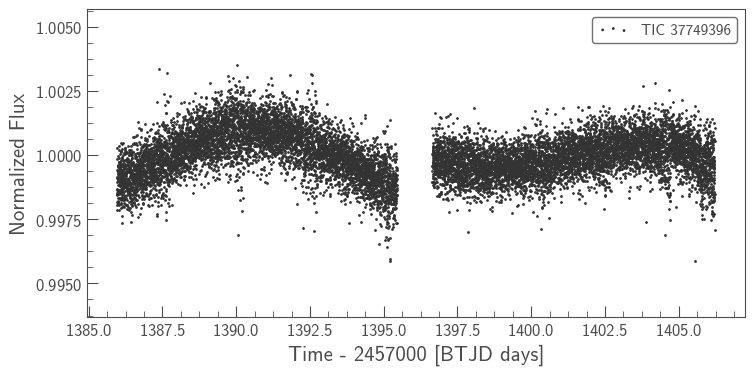

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -18271.476809637854 -> -16031.207913940798


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -13980.206080512597 -> -13432.695839060714


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13432.695839060714 -> -13400.430506737204


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13400.430506737204 -> -13400.428349243968


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -13400.428349243968 -> -13398.451511520967


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -13398.451511520967 -> -13398.18440270732


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13398.18440270732 -> -13393.827564431445


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -13393.827564431445 -> -13393.827564431445


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -13393.827564431445 -> -13393.827564431445


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13393.827564431445 -> -13393.827564431445


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -13393.827564431445 -> -13393.827564431445


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -13393.827564431445 -> -13393.827564431445


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13393.827564431445 -> -13393.827564431445


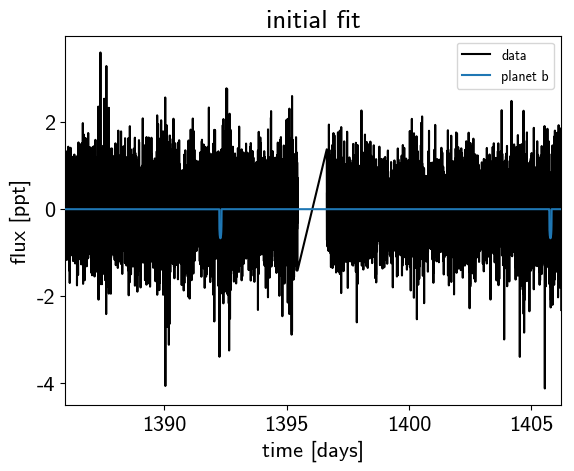

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 14.58draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  8.30draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:12,  7.16draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:23,  3.95draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:24,  3.66draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:24,  3.59draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:22,  3.88draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:24,  3.41draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:22,  3.74draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:23,  3.49draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:21,  3.77draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:23,  3.43draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:20,  3.89draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:26,  3.04draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:20,  3.74draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:25,  2.98draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:25,  2.99draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:26,  2.86draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:28,  2.64draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:23,  3.10draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:27,  2.61draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:24,  2.81draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:23,  2.91draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:21,  3.12draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:18,  3.43draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:17,  3.70draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:15,  3.89draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:17,  3.42draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:14,  4.19draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:18,  3.17draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:15,  3.87draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:17,  3.35draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:16,  3.45draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:14,  3.88draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:16,  3.21draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:13,  3.95draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:14,  3.55draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:16,  3.07draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:16,  2.95draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:14,  3.17draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:15,  3.04draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:12,  3.50draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:13,  3.16draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:11,  3.80draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:14,  2.96draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:12,  3.08draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:17<00:10,  3.65draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:11,  3.20draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:11,  3.27draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:10,  3.52draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:11,  3.12draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:19<00:09,  3.37draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:08,  3.81draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:19<00:09,  3.29draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:20<00:08,  3.43draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:20<00:08,  3.23draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:08,  3.25draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:20<00:07,  3.59draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:07,  3.28draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:21<00:06,  3.90draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:21<00:07,  3.34draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:22<00:05,  3.87draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:22<00:05,  3.80draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:22<00:06,  3.02draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:23<00:05,  3.22draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:23<00:04,  3.56draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:04,  3.49draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:24<00:04,  3.48draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:03,  3.90draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:24<00:04,  3.08draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:25<00:03,  3.26draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:02,  3.66draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:25<00:02,  3.60draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:26<00:02,  2.87draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:27<00:03,  2.04draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:27<00:03,  1.86draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:28<00:02,  2.11draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:28<00:01,  2.26draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:29<00:01,  1.92draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:29<00:01,  1.87draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:30<00:00,  1.85draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:32<00:00,  1.06s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:01, 61.55draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:12,  7.48draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:18,  4.90draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:20,  4.33draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:21,  4.04draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:18,  4.62draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:19,  4.30draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:18,  4.61draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:18,  4.36draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:19,  4.14draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:21,  3.79draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:18,  4.18draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:21,  3.65draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:19,  3.95draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:17,  4.32draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:21,  3.55draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:17,  4.17draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:20,  3.51draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:19,  3.68draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:16,  4.23draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:16,  4.32draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:17,  3.88draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:17,  3.81draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:18,  3.60draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.75draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:18,  3.47draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:18,  3.55draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:17,  3.53draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:21,  2.82draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:19,  3.03draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:15,  3.70draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:19,  3.01draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:15,  3.72draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:18,  3.05draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:17,  3.19draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:13,  3.87draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:13,  3.91draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:17,  2.96draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:16,  3.17draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:18,  2.67draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:17,  2.84draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:16,  2.95draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:16,  2.78draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:14,  3.28draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:16,  2.69draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:12,  3.38draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:12,  3.34draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:13,  2.98draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:16<00:11,  3.61draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:13,  2.95draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:11,  3.34draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:17<00:09,  3.97draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:11,  3.13draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:18<00:10,  3.27draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:18<00:10,  3.00draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:10,  3.18draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:19<00:10,  2.97draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:10,  2.82draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:19<00:08,  3.23draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:10,  2.64draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:20<00:08,  2.91draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:21<00:08,  3.07draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:21<00:06,  3.36draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:05,  3.86draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:22<00:07,  2.92draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:22<00:06,  2.94draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:23<00:05,  3.32draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:04,  3.74draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:23<00:04,  3.16draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:03,  3.84draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:24<00:04,  3.19draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:25<00:03,  3.27draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:25<00:02,  3.36draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:26<00:02,  3.41draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:26<00:01,  3.85draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:26<00:01,  3.43draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:27<00:01,  3.51draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:27<00:00,  3.49draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:27<00:00,  2.78draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:29<00:00,  1.32draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:30<00:00,  1.28draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:12,  1.53draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<01:40,  2.02draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:19,  2.50draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:06,  2.98draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:07,  2.91draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:03,  3.09draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<00:59,  3.27draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<01:02,  3.10draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:50,  3.82draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:47,  4.03draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:53,  3.54draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:59,  3.17draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:04<00:58,  3.20draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:50,  3.67draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<00:41,  4.45draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:05<00:59,  3.13draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:05<00:49,  3.68draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:05<00:57,  3.18draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:06<00:55,  3.25draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:06<00:50,  3.59draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:06<00:55,  3.24draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:07<00:53,  3.30draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:07<00:55,  3.17draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:07<01:00,  2.93draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:08<00:50,  3.49draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:08<00:49,  3.52draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:09<00:56,  3.03draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:09<00:44,  3.83draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:09<00:59,  2.86draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:09<00:48,  3.51draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:10<00:38,  4.35draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:10<00:40,  4.13draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:10<00:30,  5.31draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:10<00:36,  4.45draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:11<00:43,  3.73draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:11<00:43,  3.64draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:11<00:44,  3.61draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:11<00:34,  4.52draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:12<00:34,  4.53draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:12<00:33,  4.56draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:12<00:39,  3.83draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:13<00:46,  3.27draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:13<00:41,  3.64draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:14<00:55,  2.71draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:14<00:53,  2.79draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:15<00:50,  2.87draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:15<00:41,  3.47draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:15<00:32,  4.42draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:16<00:42,  3.32draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:16<00:43,  3.24draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:16<00:40,  3.47draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:17<00:50,  2.78draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:17<00:40,  3.40draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:17<00:44,  3.07draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:18<00:46,  2.92draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:18<00:44,  3.04draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:19<00:41,  3.16draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:19<00:36,  3.58draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:19<00:32,  4.06draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:20<00:35,  3.65draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:20<00:38,  3.37draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:20<00:42,  2.98draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:21<00:41,  3.03draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:21<00:32,  3.81draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:21<00:26,  4.65draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:21<00:24,  5.10draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:22<00:29,  4.06draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:22<00:32,  3.68draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:23<00:23,  4.89draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:23<00:26,  4.34draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:23<00:26,  4.33draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:24<00:36,  3.11draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:24<00:29,  3.73draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:24<00:38,  2.85draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:25<00:35,  3.10draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:25<00:34,  3.17draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:25<00:34,  3.11draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:25<00:31,  3.42draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:26<00:36,  2.90draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:26<00:29,  3.57draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:27<00:39,  2.63draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:27<00:37,  2.68draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:28<00:35,  2.82draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:28<00:31,  3.18draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:29<00:32,  3.00draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:29<00:28,  3.39draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:29<00:23,  4.14draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:29<00:30,  3.15draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:30<00:24,  3.86draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:30<00:32,  2.83draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:31<00:27,  3.26draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:31<00:24,  3.54draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:32<00:30,  2.86draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:32<00:23,  3.57draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:32<00:30,  2.72draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:33<00:29,  2.76draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:33<00:23,  3.50draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:33<00:22,  3.56draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:34<00:24,  3.24draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:34<00:20,  3.87draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:34<00:22,  3.47draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:34<00:16,  4.58draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:35<00:14,  5.14draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:35<00:18,  4.03draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:35<00:17,  4.11draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:36<00:21,  3.38draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:36<00:21,  3.29draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:36<00:20,  3.30draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:36<00:16,  4.12draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:37<00:17,  3.87draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:37<00:17,  3.69draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:38<00:19,  3.33draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:38<00:16,  3.74draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:38<00:20,  2.98draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:38<00:16,  3.73draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:39<00:19,  3.07draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:39<00:15,  3.78draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:39<00:12,  4.63draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:39<00:12,  4.57draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:40<00:16,  3.27draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:40<00:13,  3.86draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:40<00:11,  4.42draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:41<00:11,  4.59draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:41<00:08,  5.56draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:41<00:11,  4.06draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:41<00:10,  4.64draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:42<00:12,  3.67draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:42<00:10,  4.20draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:42<00:09,  4.51draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:43<00:12,  3.43draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:43<00:10,  4.18draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:43<00:10,  4.08draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:43<00:11,  3.54draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:44<00:11,  3.37draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:44<00:09,  4.05draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:45<00:13,  2.76draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:45<00:11,  2.89draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:46<00:10,  3.06draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:46<00:09,  3.16draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:47<00:09,  2.92draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:48<00:07,  3.53draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:48<00:07,  3.54draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:48<00:06,  3.91draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:49<00:09,  2.52draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:49<00:10,  2.05draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:50<00:10,  1.98draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:51<00:10,  1.91draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:51<00:10,  1.82draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:52<00:09,  1.85draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:52<00:09,  1.89draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:53<00:08,  1.88draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:53<00:07,  1.91draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:54<00:07,  1.91draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:54<00:07,  1.79draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:55<00:07,  1.57draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:56<00:06,  1.61draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:57<00:06,  1.51draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:57<00:05,  1.51draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:58<00:05,  1.53draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:58<00:04,  1.60draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:59<00:03,  1.58draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:00<00:03,  1.56draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:00<00:02,  1.62draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:01<00:01,  1.68draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:02<00:01,  1.56draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:02<00:00,  1.53draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:05<00:00,  1.16s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:22, 17.84draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:22, 17.62draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:36, 10.81draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:41,  9.53draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:36, 10.91draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:01<00:48,  8.10draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<01:04,  6.04draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:01<01:02,  6.24draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:59,  6.52draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:01<00:57,  6.77draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:02<01:03,  6.11draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:02<00:55,  6.93draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:02<00:42,  8.99draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:02<00:55,  6.82draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:03<01:12,  5.17draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:03<01:12,  5.20draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:03<01:18,  4.79draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:04<01:12,  5.17draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:04<01:01,  6.04draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:04<01:04,  5.70draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:04<00:56,  6.52draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:04<00:50,  7.27draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:04<00:42,  8.62draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:05<00:35, 10.38draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:05<00:40,  9.03draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:05<00:51,  6.96draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:06<00:46,  7.73draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:06<00:39,  9.05draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:06<00:33, 10.66draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:06<00:34, 10.05draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:06<00:30, 11.58draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:06<00:27, 12.79draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:07<00:38,  8.93draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:07<01:01,  5.58draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:08<01:11,  4.81draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:08<01:02,  5.42draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:08<01:10,  4.78draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:08<01:04,  5.27draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:08<00:58,  5.81draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:09<00:54,  6.17draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:09<00:51,  6.47draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:09<00:45,  7.28draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:09<00:42,  7.81draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:09<00:36,  8.91draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:10<00:42,  7.70draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:10<00:42,  7.66draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:10<00:44,  7.23draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:10<00:41,  7.73draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:10<00:37,  8.51draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:10<00:36,  8.66draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:11<00:30, 10.31draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:11<00:26, 11.99draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:11<00:26, 11.94draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:11<00:23, 12.99draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:11<00:23, 13.11draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:11<00:19, 15.75draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:11<00:20, 14.92draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:11<00:17, 17.29draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:12<00:15, 19.66draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:12<00:14, 20.64draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:12<00:16, 17.27draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:12<00:15, 18.41draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:13<00:36,  7.74draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:14<00:51,  5.50draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:14<01:00,  4.63draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:15<01:15,  3.69draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:15<01:18,  3.56draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:15<01:23,  3.34draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:16<01:19,  3.48draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:16<01:20,  3.43draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:16<01:24,  3.24draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:16<01:14,  3.68draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:17<01:28,  3.08draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:17<01:13,  3.69draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:17<01:28,  3.07draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:18<01:26,  3.12draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:18<01:30,  2.98draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:18<01:27,  3.06draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:19<01:30,  2.95draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:19<01:24,  3.16draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:20<01:37,  2.71draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:20<01:23,  3.18draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:20<01:24,  3.10draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:20<01:21,  3.21draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:21<01:04,  4.04draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:21<01:09,  3.72draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:21<01:00,  4.29draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:21<00:53,  4.77draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:21<00:49,  5.19draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:22<00:43,  5.87draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:22<00:37,  6.76draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:22<00:41,  6.07draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:22<00:42,  5.90draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:22<00:34,  7.23draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:23<00:31,  7.81draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:23<00:26,  9.14draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:23<00:25,  9.44draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:23<00:21, 11.13draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:23<00:20, 11.73draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:23<00:17, 13.10draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:23<00:14, 15.63draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:24<00:16, 13.76draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:24<00:14, 16.07draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:24<00:15, 14.03draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:24<00:21, 10.34draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:25<00:18, 11.69draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:25<00:28,  7.56draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:26<00:39,  5.45draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:26<00:58,  3.63draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:26<00:53,  3.92draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:27<01:02,  3.37draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:27<01:01,  3.38draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:27<00:54,  3.83draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:28<00:54,  3.75draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:28<00:54,  3.71draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:29<00:56,  3.60draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:29<00:56,  3.54draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:30<00:51,  3.86draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:30<00:50,  3.88draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:31<00:56,  3.47draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:31<01:02,  3.12draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:31<00:54,  3.58draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:32<00:53,  3.61draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:32<00:43,  4.40draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:32<00:45,  4.16draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:32<00:40,  4.65draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:32<00:36,  5.16draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:33<00:33,  5.63draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:33<00:30,  6.02draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:33<00:23,  7.72draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:33<00:28,  6.40draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:33<00:28,  6.39draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:34<00:27,  6.55draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:34<00:30,  5.78draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:34<00:28,  6.11draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:34<00:27,  6.46draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:34<00:21,  8.02draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:34<00:22,  7.54draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:35<00:20,  8.20draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:35<00:25,  6.61draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:35<00:24,  6.67draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:35<00:24,  6.69draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:36<00:25,  6.47draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:36<00:26,  6.05draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:36<00:29,  5.55draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:36<00:27,  5.79draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:37<00:29,  5.36draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:37<00:28,  5.45draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:37<00:25,  6.20draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:37<00:21,  7.02draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:37<00:19,  7.67draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:37<00:15,  9.45draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:37<00:13, 11.05draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:38<00:12, 11.74draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:38<00:11, 12.86draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:38<00:11, 12.65draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:38<00:10, 12.85draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:39<00:29,  4.62draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:40<00:44,  3.02draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:41<00:54,  2.47draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:42<01:05,  2.03draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:42<01:09,  1.90draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:43<01:18,  1.66draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:44<01:18,  1.66draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:44<01:13,  1.76draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:45<01:10,  1.81draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:45<01:09,  1.82draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:46<01:10,  1.80draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:46<01:08,  1.82draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:47<01:09,  1.79draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:47<01:09,  1.77draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:48<01:08,  1.79draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:49<01:06,  1.83draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:49<01:04,  1.85draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:50<01:03,  1.89draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:50<01:02,  1.88draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:51<01:02,  1.86draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:51<01:03,  1.83draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:52<01:03,  1.81draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:52<01:01,  1.84draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:53<01:01,  1.82draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:54<01:06,  1.69draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:54<01:06,  1.67draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:55<01:07,  1.63draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:55<01:03,  1.71draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:56<01:02,  1.74draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:56<00:49,  2.13draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:57<00:53,  1.96draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:58<00:54,  1.90draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:58<00:55,  1.86draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:59<00:55,  1.84draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:59<00:54,  1.87draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [01:00<00:53,  1.89draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [01:00<00:53,  1.84draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [01:01<00:51,  1.90draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [01:01<00:51,  1.90draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [01:02<00:53,  1.78draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [01:02<00:52,  1.81draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [01:03<00:59,  1.59draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [01:04<01:00,  1.53draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [01:05<00:58,  1.58draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [01:05<00:55,  1.64draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [01:06<00:51,  1.73draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [01:06<00:51,  1.73draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [01:07<00:55,  1.60draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [01:07<00:47,  1.85draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [01:08<00:52,  1.64draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [01:09<00:56,  1.50draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [01:09<00:55,  1.51draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [01:10<00:53,  1.56draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [01:11<00:49,  1.64draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [01:11<00:40,  1.98draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [01:11<00:42,  1.90draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [01:12<00:41,  1.88draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [01:12<00:41,  1.90draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [01:13<00:40,  1.88draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [01:14<00:42,  1.80draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [01:14<00:40,  1.85draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [01:15<00:39,  1.87draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [01:15<00:37,  1.93draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [01:16<00:37,  1.90draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [01:16<00:32,  2.20draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [01:16<00:27,  2.54draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [01:17<00:30,  2.25draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [01:17<00:32,  2.11draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [01:18<00:34,  1.97draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [01:18<00:33,  1.95draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [01:19<00:35,  1.85draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [01:20<00:34,  1.86draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [01:20<00:35,  1.75draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [01:21<00:39,  1.56draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [01:22<00:37,  1.62draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [01:22<00:35,  1.68draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [01:22<00:29,  2.00draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [01:23<00:24,  2.37draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [01:23<00:20,  2.72draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [01:23<00:18,  2.98draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [01:23<00:16,  3.31draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [01:24<00:13,  3.93draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [01:24<00:13,  3.91draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [01:24<00:11,  4.58draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [01:24<00:09,  5.26draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [01:24<00:10,  4.84draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [01:24<00:08,  6.00draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [01:25<00:07,  6.44draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [01:25<00:06,  6.89draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [01:25<00:06,  7.15draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [01:25<00:06,  7.13draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [01:25<00:06,  7.01draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [01:25<00:05,  7.17draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [01:25<00:04,  8.80draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [01:26<00:04,  9.32draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [01:26<00:04,  8.57draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [01:26<00:05,  6.54draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [01:26<00:04,  7.29draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [01:26<00:03,  7.94draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [01:27<00:03,  9.46draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [01:27<00:03,  8.95draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [01:27<00:02,  9.52draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [01:27<00:02,  9.49draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [01:27<00:02,  9.53draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [01:28<00:02,  8.60draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:28<00:02,  7.00draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:28<00:01,  8.09draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:29<00:01,  7.86draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:29<00:02,  4.07draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:30<00:03,  2.95draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:30<00:03,  2.53draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:31<00:03,  2.30draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:31<00:02,  2.21draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:32<00:02,  2.16draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:32<00:01,  2.02draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:33<00:01,  1.99draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:34<00:01,  1.81draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:34<00:00,  1.75draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:34<00:00,  2.09draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:20, 39.70draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:26, 30.04draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:35, 22.33draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<01:09, 11.49draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:01<01:24,  9.32draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:01<01:28,  8.88draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:01<01:45,  7.45draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:35,  8.20draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<01:23,  9.41draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<01:09, 11.32draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:02<01:03, 12.26draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:02<00:59, 13.06draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:02<00:57, 13.49draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:02<01:05, 11.76draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:02<01:14, 10.30draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:02<01:06, 11.63draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:03<00:58, 13.11draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:03<01:07, 11.29draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:03<01:17,  9.92draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:03<01:40,  7.60draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:04<01:57,  6.46draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:04<01:41,  7.48draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:04<01:39,  7.60draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:04<01:25,  8.87draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:04<01:22,  9.09draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:05<01:33,  8.06draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:05<01:28,  8.52draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:05<01:30,  8.24draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:05<01:31,  8.17draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:05<01:24,  8.87draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:06<02:22,  5.22draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:06<03:32,  3.49draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:06<03:11,  3.88draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:07<03:22,  3.66draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:07<02:48,  4.41draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:07<02:24,  5.14draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:07<02:15,  5.47draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:07<02:00,  6.11draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:07<02:01,  6.05draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:07<01:50,  6.64draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:08<01:27,  8.40draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:08<01:31,  8.00draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:08<01:32,  7.84draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:08<01:36,  7.54draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:08<01:41,  7.19draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:09<01:28,  8.16draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:09<01:21,  8.83draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:09<01:17,  9.33draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:09<01:34,  7.60draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:10<02:12,  5.43draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:10<03:07,  3.83draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:11<03:10,  3.76draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:11<02:38,  4.52draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:11<03:44,  3.18draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:12<03:04,  3.85draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:12<03:00,  3.94draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:12<02:42,  4.37draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:12<02:10,  5.44draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:12<02:25,  4.84draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:13<02:12,  5.33draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:13<01:51,  6.30draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:13<02:00,  5.80draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:13<01:52,  6.23draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:13<01:37,  7.12draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:14<02:01,  5.75draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:14<01:47,  6.45draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:14<01:26,  7.99draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:14<01:22,  8.34draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:14<01:14,  9.25draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:14<01:09,  9.84draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:15<00:56, 12.17draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:15<01:02, 10.83draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:15<01:01, 10.98draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:15<00:59, 11.36draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:15<00:54, 12.32draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:15<00:52, 12.89draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:16<01:06, 10.08draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:16<00:56, 11.78draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:16<00:50, 13.17draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:16<00:48, 13.66draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:16<00:40, 16.19draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:16<00:40, 16.22draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:17<00:48, 13.65draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:17<00:44, 14.53draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:17<00:38, 16.75draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:17<00:39, 16.51draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:17<00:44, 14.62draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:17<00:47, 13.63draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:18<00:53, 12.07draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:18<01:04,  9.94draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:18<01:32,  6.92draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:19<01:42,  6.25draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:19<01:27,  7.23draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:19<01:33,  6.80draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:19<01:18,  8.05draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:19<01:02, 10.10draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:20<02:06,  4.97draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:20<02:08,  4.88draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:21<02:12,  4.70draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:21<02:28,  4.19draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:21<02:16,  4.56draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:22<02:57,  3.49draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:22<02:49,  3.65draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:23<02:43,  3.78draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:23<02:37,  3.91draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:24<02:34,  3.98draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:24<02:34,  3.97draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:24<02:37,  3.88draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:25<02:37,  3.86draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:25<02:15,  4.49draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:25<02:43,  3.72draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:26<02:44,  3.67draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:26<02:22,  4.22draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:26<02:21,  4.24draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:27<02:04,  4.83draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:27<01:56,  5.13draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:27<01:52,  5.34draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:27<01:32,  6.44draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:27<01:34,  6.28draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:27<01:37,  6.10draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:28<01:23,  7.11draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:28<01:12,  8.08draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:28<01:13,  8.03draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:28<01:15,  7.72draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:29<01:17,  7.57draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:29<01:28,  6.61draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:29<01:57,  4.94draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:29<01:38,  5.89draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:29<01:37,  5.92draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:30<01:18,  7.36draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:30<01:05,  8.83draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:30<01:01,  9.28draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:30<00:56, 10.02draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:30<00:49, 11.54draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:30<00:42, 13.38draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:30<00:39, 14.19draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:31<00:38, 14.56draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:31<00:39, 14.12draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:31<00:43, 12.75draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:31<00:45, 12.31draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:31<00:48, 11.36draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:31<00:46, 11.94draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:32<00:59,  9.19draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:32<00:55,  9.90draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:32<00:52, 10.40draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:32<00:46, 11.78draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:32<00:45, 11.79draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:33<00:45, 11.74draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:33<00:44, 12.20draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:33<00:44, 12.05draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:33<00:50, 10.49draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:33<00:48, 10.87draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:34<00:54,  9.64draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:34<00:54,  9.60draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:34<00:55,  9.52draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:34<01:00,  8.70draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:34<01:06,  7.84draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:34<01:05,  7.99draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:34<01:00,  8.57draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:35<01:09,  7.54draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:35<01:01,  8.41draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:35<00:51,  9.97draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:35<00:49, 10.40draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:35<00:44, 11.56draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:36<00:41, 12.26draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:36<00:51,  9.88draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:36<00:48, 10.31draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:36<00:47, 10.63draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:36<00:59,  8.48draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:37<00:51,  9.72draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:37<00:43, 11.42draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:37<00:43, 11.45draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:37<00:43, 11.35draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:37<00:43, 11.27draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:37<00:38, 12.76draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:38<00:50,  9.55draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:38<00:52,  9.27draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:38<00:46, 10.40draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:38<00:48,  9.97draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:39<00:44, 10.71draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:39<00:41, 11.36draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:39<00:44, 10.75draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:39<00:53,  8.85draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:39<00:50,  9.22draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:40<00:44, 10.46draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:40<00:49,  9.50draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:40<00:44, 10.45draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:40<00:57,  8.06draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:41<01:10,  6.54draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:41<01:05,  6.98draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:41<01:30,  5.06draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:41<01:34,  4.86draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:41<01:29,  5.10draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:42<01:19,  5.72draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:42<01:21,  5.54draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:42<01:20,  5.65draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:42<01:03,  7.13draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:42<01:13,  6.15draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:42<01:18,  5.69draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:43<01:08,  6.55draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:43<01:02,  7.13draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:43<00:59,  7.48draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:43<00:54,  8.05draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:43<01:06,  6.62draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:44<01:14,  5.89draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:44<00:59,  7.33draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:44<01:10,  6.21draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:44<01:03,  6.89draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:44<00:59,  7.27draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:45<00:55,  7.77draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:45<00:57,  7.42draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:45<00:47,  9.02draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:45<00:45,  9.25draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:45<00:43,  9.75draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:46<00:39, 10.76draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:46<00:44,  9.48draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:46<00:37, 11.12draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:46<00:45,  9.21draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:46<00:41, 10.04draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:47<00:38, 10.64draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:47<00:42,  9.60draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:47<00:43,  9.28draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:47<00:46,  8.77draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:47<01:00,  6.68draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:48<01:01,  6.52draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:48<00:56,  7.13draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:48<01:06,  6.01draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:49<01:14,  5.32draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:49<01:16,  5.18draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:49<01:07,  5.80draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:49<01:12,  5.44draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:50<01:09,  5.63draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:50<01:02,  6.27draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:50<01:00,  6.38draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:50<00:56,  6.91draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:50<00:49,  7.75draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:50<00:54,  7.11draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:51<00:46,  8.27draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:51<00:49,  7.68draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:51<00:47,  7.92draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [00:51<00:38,  9.68draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:51<00:40,  9.29draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:52<00:40,  9.22draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:52<00:38,  9.64draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:52<00:39,  9.34draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:52<00:36, 10.18draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:52<00:29, 12.20draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:53<00:33, 10.77draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:53<00:32, 11.21draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:53<00:26, 13.70draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:53<00:41,  8.49draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:54<00:51,  6.92draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:54<00:51,  6.79draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:54<00:50,  6.87draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:54<00:48,  7.14draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:54<00:48,  7.20draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:55<00:49,  6.96draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:55<00:50,  6.92draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:55<00:50,  6.83draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:55<00:49,  6.91draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:55<00:49,  6.97draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:55<00:49,  6.89draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:55<00:49,  6.89draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:56<00:54,  6.27draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:56<00:58,  5.82draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:56<00:51,  6.54draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:56<00:57,  5.81draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:56<00:51,  6.50draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:56<00:47,  7.08draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:56<00:43,  7.62draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:57<00:41,  8.02draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:57<00:39,  8.30draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:57<00:38,  8.64draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:57<00:37,  8.74draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:57<00:36,  8.89draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:57<00:36,  9.00draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:57<00:30, 10.64draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:57<00:29, 11.09draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:58<00:30, 10.42draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:58<00:30, 10.58draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:58<00:34,  9.23draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:58<00:41,  7.61draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:58<00:46,  6.84draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:59<00:48,  6.53draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:59<00:41,  7.57draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:59<00:35,  8.73draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:59<00:32,  9.45draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:59<00:27, 11.11draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:59<00:26, 11.39draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [01:00<00:30, 10.05draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [01:00<00:31,  9.59draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [01:00<00:27, 10.65draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [01:00<00:25, 11.61draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [01:00<00:24, 12.07draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [01:01<00:27, 10.64draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [01:01<00:28, 10.24draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [01:01<00:31,  9.17draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [01:01<00:26, 10.64draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [01:01<00:27, 10.41draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [01:02<00:23, 11.76draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [01:02<00:21, 12.79draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [01:02<00:25, 10.99draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [01:02<00:27,  9.92draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [01:02<00:30,  8.95draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [01:03<00:28,  9.46draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [01:03<00:28,  9.30draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [01:03<00:28,  9.41draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [01:03<00:28,  9.26draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [01:03<00:29,  9.01draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [01:03<00:24, 10.71draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [01:04<00:27,  9.58draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [01:04<00:28,  9.06draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [01:04<00:39,  6.49draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [01:04<00:36,  6.99draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [01:04<00:34,  7.36draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [01:04<00:34,  7.43draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [01:05<00:27,  9.13draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [01:05<00:25,  9.91draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [01:05<00:24, 10.01draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [01:05<00:31,  7.96draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [01:05<00:30,  8.00draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [01:06<00:36,  6.70draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [01:06<00:39,  6.13draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [01:06<00:36,  6.66draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [01:06<00:38,  6.28draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [01:06<00:39,  6.08draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [01:07<00:40,  5.94draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [01:07<00:34,  6.94draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [01:07<00:34,  6.83draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [01:07<00:35,  6.55draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [01:07<00:35,  6.58draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [01:07<00:35,  6.62draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [01:08<00:33,  6.90draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [01:08<00:32,  7.10draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [01:08<00:34,  6.63draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [01:08<00:36,  6.30draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [01:08<00:37,  6.10draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [01:09<00:37,  5.95draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [01:09<00:38,  5.85draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [01:09<00:38,  5.77draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [01:09<00:32,  6.77draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [01:09<00:26,  8.24draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [01:09<00:23,  9.38draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [01:10<00:21,  9.94draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [01:10<00:19, 10.96draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [01:10<00:17, 12.13draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [01:10<00:19, 10.73draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [01:10<00:20, 10.07draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [01:11<00:23,  8.70draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [01:11<00:26,  7.58draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [01:11<00:29,  6.89draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [01:11<00:28,  7.08draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [01:11<00:28,  7.09draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [01:11<00:27,  7.35draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [01:12<00:22,  8.76draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [01:12<00:21,  8.94draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [01:13<01:52,  1.73draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [01:16<03:53,  1.20s/draws]

Sampling 2 chains:  76%|███████▌  | 611/804 [01:19<05:10,  1.61s/draws]

Sampling 2 chains:  76%|███████▌  | 612/804 [01:21<06:06,  1.91s/draws]

Sampling 2 chains:  76%|███████▌  | 613/804 [01:23<06:12,  1.95s/draws]

Sampling 2 chains:  76%|███████▋  | 614/804 [01:25<06:07,  1.93s/draws]

Sampling 2 chains:  76%|███████▋  | 615/804 [01:27<05:59,  1.90s/draws]

Sampling 2 chains:  77%|███████▋  | 616/804 [01:29<05:54,  1.89s/draws]

Sampling 2 chains:  77%|███████▋  | 617/804 [01:31<05:49,  1.87s/draws]

Sampling 2 chains:  77%|███████▋  | 618/804 [01:33<06:28,  2.09s/draws]

Sampling 2 chains:  77%|███████▋  | 619/804 [01:36<06:43,  2.18s/draws]

Sampling 2 chains:  77%|███████▋  | 620/804 [01:38<07:09,  2.33s/draws]

Sampling 2 chains:  77%|███████▋  | 621/804 [01:40<06:44,  2.21s/draws]

Sampling 2 chains:  77%|███████▋  | 622/804 [01:42<06:32,  2.16s/draws]

Sampling 2 chains:  77%|███████▋  | 623/804 [01:44<06:20,  2.10s/draws]

Sampling 2 chains:  78%|███████▊  | 624/804 [01:47<06:54,  2.30s/draws]

Sampling 2 chains:  78%|███████▊  | 625/804 [01:49<06:28,  2.17s/draws]

Sampling 2 chains:  78%|███████▊  | 626/804 [01:51<06:20,  2.14s/draws]

Sampling 2 chains:  78%|███████▊  | 627/804 [01:53<06:12,  2.11s/draws]

Sampling 2 chains:  78%|███████▊  | 628/804 [01:56<06:37,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 629/804 [01:58<06:33,  2.25s/draws]

Sampling 2 chains:  78%|███████▊  | 630/804 [02:00<06:48,  2.35s/draws]

Sampling 2 chains:  78%|███████▊  | 631/804 [02:03<06:49,  2.36s/draws]

Sampling 2 chains:  79%|███████▊  | 632/804 [02:05<06:35,  2.30s/draws]

Sampling 2 chains:  79%|███████▊  | 633/804 [02:07<06:28,  2.27s/draws]

Sampling 2 chains:  79%|███████▉  | 634/804 [02:09<06:10,  2.18s/draws]

Sampling 2 chains:  79%|███████▉  | 635/804 [02:11<06:12,  2.20s/draws]

Sampling 2 chains:  79%|███████▉  | 636/804 [02:13<05:46,  2.06s/draws]

Sampling 2 chains:  79%|███████▉  | 637/804 [02:15<05:47,  2.08s/draws]

Sampling 2 chains:  79%|███████▉  | 638/804 [02:17<05:37,  2.04s/draws]

Sampling 2 chains:  79%|███████▉  | 639/804 [02:19<05:34,  2.03s/draws]

Sampling 2 chains:  80%|███████▉  | 640/804 [02:21<05:39,  2.07s/draws]

Sampling 2 chains:  80%|███████▉  | 641/804 [02:23<05:34,  2.05s/draws]

Sampling 2 chains:  80%|███████▉  | 642/804 [02:25<05:29,  2.03s/draws]

Sampling 2 chains:  80%|███████▉  | 643/804 [02:28<05:34,  2.08s/draws]

Sampling 2 chains:  80%|████████  | 644/804 [02:30<05:32,  2.08s/draws]

Sampling 2 chains:  80%|████████  | 645/804 [02:32<05:33,  2.10s/draws]

Sampling 2 chains:  80%|████████  | 646/804 [02:34<05:50,  2.22s/draws]

Sampling 2 chains:  80%|████████  | 647/804 [02:36<05:45,  2.20s/draws]

Sampling 2 chains:  81%|████████  | 648/804 [02:38<05:34,  2.15s/draws]

Sampling 2 chains:  81%|████████  | 649/804 [02:41<05:37,  2.18s/draws]

Sampling 2 chains:  81%|████████  | 650/804 [02:43<05:24,  2.11s/draws]

Sampling 2 chains:  81%|████████  | 651/804 [02:45<05:34,  2.19s/draws]

Sampling 2 chains:  81%|████████  | 652/804 [02:47<05:40,  2.24s/draws]

Sampling 2 chains:  81%|████████  | 653/804 [02:50<06:16,  2.49s/draws]

Sampling 2 chains:  81%|████████▏ | 654/804 [02:53<05:54,  2.37s/draws]

Sampling 2 chains:  81%|████████▏ | 655/804 [02:55<05:39,  2.28s/draws]

Sampling 2 chains:  82%|████████▏ | 656/804 [02:57<05:31,  2.24s/draws]

Sampling 2 chains:  82%|████████▏ | 657/804 [02:59<05:30,  2.25s/draws]

Sampling 2 chains:  82%|████████▏ | 658/804 [03:01<05:10,  2.12s/draws]

Sampling 2 chains:  82%|████████▏ | 659/804 [03:03<05:06,  2.12s/draws]

Sampling 2 chains:  82%|████████▏ | 660/804 [03:05<04:56,  2.06s/draws]

Sampling 2 chains:  82%|████████▏ | 661/804 [03:07<04:47,  2.01s/draws]

Sampling 2 chains:  82%|████████▏ | 662/804 [03:09<04:37,  1.96s/draws]

Sampling 2 chains:  82%|████████▏ | 663/804 [03:10<04:29,  1.91s/draws]

Sampling 2 chains:  83%|████████▎ | 664/804 [03:12<04:18,  1.85s/draws]

Sampling 2 chains:  83%|████████▎ | 665/804 [03:14<04:20,  1.87s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [03:17<04:53,  2.12s/draws]

Sampling 2 chains:  83%|████████▎ | 667/804 [03:19<04:48,  2.11s/draws]

Sampling 2 chains:  83%|████████▎ | 668/804 [03:21<04:39,  2.06s/draws]

Sampling 2 chains:  83%|████████▎ | 669/804 [03:23<04:35,  2.04s/draws]

Sampling 2 chains:  83%|████████▎ | 670/804 [03:25<04:48,  2.16s/draws]

Sampling 2 chains:  83%|████████▎ | 671/804 [03:27<04:40,  2.11s/draws]

Sampling 2 chains:  84%|████████▎ | 672/804 [03:29<04:31,  2.05s/draws]

Sampling 2 chains:  84%|████████▎ | 673/804 [03:31<04:20,  1.99s/draws]

Sampling 2 chains:  84%|████████▍ | 674/804 [03:33<04:18,  1.99s/draws]

Sampling 2 chains:  84%|████████▍ | 675/804 [03:36<04:42,  2.19s/draws]

Sampling 2 chains:  84%|████████▍ | 676/804 [03:38<04:56,  2.32s/draws]

Sampling 2 chains:  84%|████████▍ | 677/804 [03:40<04:39,  2.20s/draws]

Sampling 2 chains:  84%|████████▍ | 678/804 [03:42<04:27,  2.12s/draws]

Sampling 2 chains:  84%|████████▍ | 679/804 [03:44<04:11,  2.01s/draws]

Sampling 2 chains:  85%|████████▍ | 680/804 [03:46<04:07,  2.00s/draws]

Sampling 2 chains:  85%|████████▍ | 681/804 [03:48<04:01,  1.96s/draws]

Sampling 2 chains:  85%|████████▍ | 682/804 [03:50<04:01,  1.98s/draws]

Sampling 2 chains:  85%|████████▍ | 683/804 [03:53<04:49,  2.39s/draws]

Sampling 2 chains:  85%|████████▌ | 684/804 [03:56<04:52,  2.44s/draws]

Sampling 2 chains:  85%|████████▌ | 685/804 [03:59<05:21,  2.70s/draws]

Sampling 2 chains:  85%|████████▌ | 686/804 [04:02<05:23,  2.74s/draws]

Sampling 2 chains:  85%|████████▌ | 687/804 [04:04<05:20,  2.74s/draws]

Sampling 2 chains:  86%|████████▌ | 688/804 [04:07<05:15,  2.72s/draws]

Sampling 2 chains:  86%|████████▌ | 689/804 [04:09<04:42,  2.45s/draws]

Sampling 2 chains:  86%|████████▌ | 690/804 [04:11<04:19,  2.28s/draws]

Sampling 2 chains:  86%|████████▌ | 691/804 [04:13<04:27,  2.37s/draws]

Sampling 2 chains:  86%|████████▌ | 692/804 [04:15<04:13,  2.26s/draws]

Sampling 2 chains:  86%|████████▌ | 693/804 [04:18<04:23,  2.37s/draws]

Sampling 2 chains:  86%|████████▋ | 694/804 [04:21<04:38,  2.53s/draws]

Sampling 2 chains:  86%|████████▋ | 695/804 [04:23<04:25,  2.44s/draws]

Sampling 2 chains:  87%|████████▋ | 696/804 [04:26<04:30,  2.50s/draws]

Sampling 2 chains:  87%|████████▋ | 697/804 [04:29<04:32,  2.55s/draws]

Sampling 2 chains:  87%|████████▋ | 698/804 [04:31<04:31,  2.56s/draws]

Sampling 2 chains:  87%|████████▋ | 699/804 [04:33<04:11,  2.40s/draws]

Sampling 2 chains:  87%|████████▋ | 700/804 [04:35<04:03,  2.34s/draws]

Sampling 2 chains:  87%|████████▋ | 701/804 [04:38<04:15,  2.48s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [04:40<04:01,  2.37s/draws]

Sampling 2 chains:  87%|████████▋ | 703/804 [04:42<03:53,  2.31s/draws]

Sampling 2 chains:  88%|████████▊ | 704/804 [04:44<03:40,  2.20s/draws]

Sampling 2 chains:  88%|████████▊ | 705/804 [04:46<03:34,  2.17s/draws]

Sampling 2 chains:  88%|████████▊ | 706/804 [04:49<03:39,  2.24s/draws]

Sampling 2 chains:  88%|████████▊ | 707/804 [04:51<03:27,  2.14s/draws]

Sampling 2 chains:  88%|████████▊ | 708/804 [04:53<03:29,  2.19s/draws]

Sampling 2 chains:  88%|████████▊ | 709/804 [04:55<03:24,  2.16s/draws]

Sampling 2 chains:  88%|████████▊ | 710/804 [04:57<03:14,  2.07s/draws]

Sampling 2 chains:  88%|████████▊ | 711/804 [04:59<03:12,  2.07s/draws]

Sampling 2 chains:  89%|████████▊ | 712/804 [05:02<03:23,  2.21s/draws]

Sampling 2 chains:  89%|████████▊ | 713/804 [05:04<03:17,  2.17s/draws]

Sampling 2 chains:  89%|████████▉ | 714/804 [05:06<03:10,  2.12s/draws]

Sampling 2 chains:  89%|████████▉ | 715/804 [05:08<03:08,  2.12s/draws]

Sampling 2 chains:  89%|████████▉ | 716/804 [05:10<03:02,  2.07s/draws]

Sampling 2 chains:  89%|████████▉ | 717/804 [05:12<03:05,  2.13s/draws]

Sampling 2 chains:  89%|████████▉ | 718/804 [05:14<02:58,  2.08s/draws]

Sampling 2 chains:  89%|████████▉ | 719/804 [05:16<02:51,  2.01s/draws]

Sampling 2 chains:  90%|████████▉ | 720/804 [05:18<02:49,  2.02s/draws]

Sampling 2 chains:  90%|████████▉ | 721/804 [05:20<02:43,  1.97s/draws]

Sampling 2 chains:  90%|████████▉ | 722/804 [05:22<02:42,  1.98s/draws]

Sampling 2 chains:  90%|████████▉ | 723/804 [05:24<02:35,  1.92s/draws]

Sampling 2 chains:  90%|█████████ | 724/804 [05:25<02:33,  1.92s/draws]

Sampling 2 chains:  90%|█████████ | 725/804 [05:28<02:37,  1.99s/draws]

Sampling 2 chains:  90%|█████████ | 726/804 [05:29<02:30,  1.93s/draws]

Sampling 2 chains:  90%|█████████ | 727/804 [05:31<02:25,  1.89s/draws]

Sampling 2 chains:  91%|█████████ | 728/804 [05:33<02:22,  1.87s/draws]

Sampling 2 chains:  91%|█████████ | 729/804 [05:35<02:21,  1.89s/draws]

Sampling 2 chains:  91%|█████████ | 730/804 [05:37<02:19,  1.89s/draws]

Sampling 2 chains:  91%|█████████ | 731/804 [05:39<02:14,  1.85s/draws]

Sampling 2 chains:  91%|█████████ | 732/804 [05:40<02:12,  1.85s/draws]

Sampling 2 chains:  91%|█████████ | 733/804 [05:42<02:10,  1.84s/draws]

Sampling 2 chains:  91%|█████████▏| 734/804 [05:44<02:06,  1.80s/draws]

Sampling 2 chains:  91%|█████████▏| 735/804 [05:46<02:09,  1.87s/draws]

Sampling 2 chains:  92%|█████████▏| 736/804 [05:48<02:05,  1.85s/draws]

Sampling 2 chains:  92%|█████████▏| 737/804 [05:50<02:05,  1.88s/draws]

Sampling 2 chains:  92%|█████████▏| 738/804 [05:52<02:02,  1.85s/draws]

Sampling 2 chains:  92%|█████████▏| 739/804 [05:54<02:08,  1.98s/draws]

Sampling 2 chains:  92%|█████████▏| 740/804 [05:56<02:10,  2.04s/draws]

Sampling 2 chains:  92%|█████████▏| 741/804 [05:58<02:07,  2.02s/draws]

Sampling 2 chains:  92%|█████████▏| 742/804 [06:00<02:05,  2.02s/draws]

Sampling 2 chains:  92%|█████████▏| 743/804 [06:02<02:03,  2.03s/draws]

Sampling 2 chains:  93%|█████████▎| 744/804 [06:04<02:02,  2.04s/draws]

Sampling 2 chains:  93%|█████████▎| 745/804 [06:06<01:59,  2.03s/draws]

Sampling 2 chains:  93%|█████████▎| 746/804 [06:08<02:01,  2.09s/draws]

Sampling 2 chains:  93%|█████████▎| 747/804 [06:10<01:58,  2.08s/draws]

Sampling 2 chains:  93%|█████████▎| 748/804 [06:13<02:05,  2.23s/draws]

Sampling 2 chains:  93%|█████████▎| 749/804 [06:15<02:03,  2.24s/draws]

Sampling 2 chains:  93%|█████████▎| 750/804 [06:18<02:05,  2.33s/draws]

Sampling 2 chains:  93%|█████████▎| 751/804 [06:20<02:06,  2.39s/draws]

Sampling 2 chains:  94%|█████████▎| 752/804 [06:22<02:00,  2.32s/draws]

Sampling 2 chains:  94%|█████████▎| 753/804 [06:25<02:00,  2.36s/draws]

Sampling 2 chains:  94%|█████████▍| 754/804 [06:27<01:50,  2.21s/draws]

Sampling 2 chains:  94%|█████████▍| 755/804 [06:29<01:46,  2.16s/draws]

Sampling 2 chains:  94%|█████████▍| 756/804 [06:31<01:46,  2.22s/draws]

Sampling 2 chains:  94%|█████████▍| 757/804 [06:33<01:42,  2.18s/draws]

Sampling 2 chains:  94%|█████████▍| 758/804 [06:36<01:43,  2.25s/draws]

Sampling 2 chains:  94%|█████████▍| 759/804 [06:38<01:35,  2.12s/draws]

Sampling 2 chains:  95%|█████████▍| 760/804 [06:39<01:29,  2.03s/draws]

Sampling 2 chains:  95%|█████████▍| 761/804 [06:41<01:27,  2.04s/draws]

Sampling 2 chains:  95%|█████████▍| 762/804 [06:43<01:22,  1.97s/draws]

Sampling 2 chains:  95%|█████████▍| 763/804 [06:46<01:25,  2.08s/draws]

Sampling 2 chains:  95%|█████████▌| 764/804 [06:48<01:29,  2.23s/draws]

Sampling 2 chains:  95%|█████████▌| 765/804 [06:51<01:33,  2.41s/draws]

Sampling 2 chains:  95%|█████████▌| 766/804 [06:53<01:26,  2.28s/draws]

Sampling 2 chains:  95%|█████████▌| 767/804 [06:55<01:21,  2.19s/draws]

Sampling 2 chains:  96%|█████████▌| 768/804 [06:57<01:15,  2.11s/draws]

Sampling 2 chains:  96%|█████████▌| 769/804 [07:00<01:21,  2.32s/draws]

Sampling 2 chains:  96%|█████████▌| 770/804 [07:02<01:23,  2.46s/draws]

Sampling 2 chains:  96%|█████████▌| 771/804 [07:04<01:15,  2.29s/draws]

Sampling 2 chains:  96%|█████████▌| 772/804 [07:06<01:10,  2.22s/draws]

Sampling 2 chains:  96%|█████████▌| 773/804 [07:09<01:08,  2.21s/draws]

Sampling 2 chains:  96%|█████████▋| 774/804 [07:11<01:04,  2.16s/draws]

Sampling 2 chains:  96%|█████████▋| 775/804 [07:13<01:00,  2.09s/draws]

Sampling 2 chains:  97%|█████████▋| 776/804 [07:15<00:58,  2.08s/draws]

Sampling 2 chains:  97%|█████████▋| 777/804 [07:17<01:02,  2.30s/draws]

Sampling 2 chains:  97%|█████████▋| 778/804 [07:19<00:58,  2.24s/draws]

Sampling 2 chains:  97%|█████████▋| 779/804 [07:21<00:53,  2.14s/draws]

Sampling 2 chains:  97%|█████████▋| 780/804 [07:23<00:49,  2.06s/draws]

Sampling 2 chains:  97%|█████████▋| 781/804 [07:25<00:46,  2.03s/draws]

Sampling 2 chains:  97%|█████████▋| 782/804 [07:27<00:43,  1.99s/draws]

Sampling 2 chains:  97%|█████████▋| 783/804 [07:29<00:40,  1.93s/draws]

Sampling 2 chains:  98%|█████████▊| 784/804 [07:31<00:37,  1.87s/draws]

Sampling 2 chains:  98%|█████████▊| 785/804 [07:33<00:38,  2.02s/draws]

Sampling 2 chains:  98%|█████████▊| 786/804 [07:35<00:35,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 787/804 [07:37<00:33,  1.99s/draws]

Sampling 2 chains:  98%|█████████▊| 788/804 [07:39<00:32,  2.01s/draws]

Sampling 2 chains:  98%|█████████▊| 789/804 [07:41<00:31,  2.12s/draws]

Sampling 2 chains:  98%|█████████▊| 790/804 [07:44<00:30,  2.17s/draws]

Sampling 2 chains:  98%|█████████▊| 791/804 [07:45<00:26,  2.07s/draws]

Sampling 2 chains:  99%|█████████▊| 792/804 [07:48<00:26,  2.17s/draws]

Sampling 2 chains:  99%|█████████▊| 793/804 [07:50<00:23,  2.15s/draws]

Sampling 2 chains:  99%|█████████▉| 794/804 [07:52<00:21,  2.15s/draws]

Sampling 2 chains:  99%|█████████▉| 795/804 [07:55<00:20,  2.27s/draws]

Sampling 2 chains:  99%|█████████▉| 796/804 [07:57<00:17,  2.24s/draws]

Sampling 2 chains:  99%|█████████▉| 797/804 [07:59<00:15,  2.19s/draws]

Sampling 2 chains:  99%|█████████▉| 798/804 [08:02<00:14,  2.43s/draws]

Sampling 2 chains:  99%|█████████▉| 799/804 [08:04<00:11,  2.25s/draws]

Sampling 2 chains: 100%|█████████▉| 800/804 [08:05<00:08,  2.10s/draws]

Sampling 2 chains: 100%|█████████▉| 801/804 [08:07<00:06,  2.04s/draws]

Sampling 2 chains: 100%|█████████▉| 802/804 [08:10<00:04,  2.11s/draws]

Sampling 2 chains: 100%|█████████▉| 803/804 [08:12<00:02,  2.20s/draws]

Sampling 2 chains: 100%|██████████| 804/804 [08:14<00:00,  2.13s/draws]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<02:41, 27.32draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<03:23, 21.58draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<03:55, 18.64draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<04:13, 17.31draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<04:45, 15.37draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<04:41, 15.60draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:01<03:56, 18.56draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:01<03:51, 18.90draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:01<04:18, 16.94draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<04:43, 15.44draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<04:22, 16.65draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<04:14, 17.20draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:02<04:01, 18.08draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:02<04:07, 17.66draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:02<04:10, 17.43draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:02<03:56, 18.45draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<03:35, 20.19draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:02<03:14, 22.38draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<03:40, 19.74draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:03<04:21, 16.65draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:03<04:59, 14.52draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:03<04:48, 15.08draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:03<04:27, 16.25draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:03<04:13, 17.13draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:03<03:51, 18.71draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:03<03:45, 19.17draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:04<03:24, 21.20draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:04<03:40, 19.58draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:04<03:37, 19.87draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:04<03:36, 19.96draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:04<03:34, 20.09draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:04<03:17, 21.82draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:04<03:02, 23.58draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:05<02:54, 24.63draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:05<02:39, 27.04draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:05<02:44, 26.20draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:05<03:14, 22.07draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:05<03:52, 18.50draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:05<03:48, 18.78draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:05<03:45, 19.03draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:06<03:36, 19.81draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:06<03:33, 20.09draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:06<03:38, 19.62draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:06<04:00, 17.77draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:06<04:10, 17.06draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:06<04:32, 15.69draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:07<03:58, 17.92draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:07<04:30, 15.79draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:07<03:48, 18.62draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:07<03:23, 20.93draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:07<03:01, 23.47draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:07<02:45, 25.71draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:07<02:27, 28.74draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:08<03:03, 23.15draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:08<03:26, 20.57draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:08<03:14, 21.76draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:08<03:00, 23.51draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:08<02:51, 24.60draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:08<02:46, 25.42draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:08<02:41, 26.20draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:08<02:28, 28.49draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:09<02:30, 28.02draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:09<02:40, 26.17draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:09<02:51, 24.51draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:09<03:16, 21.45draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:09<03:05, 22.65draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:09<03:47, 18.47draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:10<04:57, 14.11draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:10<04:35, 15.24draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:10<04:20, 16.10draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:10<04:10, 16.71draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:10<03:53, 17.90draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:10<03:47, 18.41draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:11<03:32, 19.64draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:11<04:11, 16.60draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:11<04:08, 16.83draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:11<03:45, 18.55draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:11<03:50, 18.07draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:11<03:43, 18.67draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:11<03:26, 20.13draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:12<03:41, 18.81draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:12<03:39, 18.98draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:12<03:27, 20.04draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:12<04:08, 16.72draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:12<04:17, 16.11draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:12<04:23, 15.75draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:13<05:21, 12.90draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:13<05:12, 13.25draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:13<04:23, 15.71draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:13<04:42, 14.67draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:13<04:24, 15.65draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:13<04:27, 15.46draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:14<06:19, 10.89draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:14<06:49, 10.10draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:14<07:11,  9.56draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:14<06:28, 10.62draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:15<06:18, 10.90draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:15<05:40, 12.10draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:15<05:18, 12.92draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:15<05:16, 13.00draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:15<04:48, 14.27draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:15<04:26, 15.45draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:15<04:39, 14.68draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:16<04:26, 15.41draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:16<04:10, 16.39draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:16<04:05, 16.69draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:16<04:08, 16.53draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:16<03:30, 19.44draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:16<03:20, 20.41draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:16<03:17, 20.68draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:16<02:51, 23.86draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:17<03:14, 20.98draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:17<03:25, 19.85draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:17<02:57, 22.95draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:17<03:58, 17.08draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:18<04:48, 14.11draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:18<05:42, 11.89draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:18<05:55, 11.43draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:18<05:30, 12.31draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:18<05:27, 12.40draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:18<05:59, 11.28draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:19<05:59, 11.29draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:19<05:36, 12.07draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:19<04:59, 13.53draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:19<05:03, 13.36draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:19<04:35, 14.68draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:19<05:31, 12.21draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:20<05:01, 13.42draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:20<05:41, 11.85draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:20<06:14, 10.79draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:20<05:44, 11.73draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:20<05:09, 13.02draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:20<05:48, 11.58draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:21<05:56, 11.32draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:21<05:15, 12.78draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:21<07:29,  8.96draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:21<06:21, 10.56draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:21<06:04, 11.05draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:22<05:38, 11.87draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:22<05:43, 11.69draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:22<05:25, 12.36draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:22<05:29, 12.17draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:22<05:36, 11.91draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:22<05:04, 13.15draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:23<05:08, 13.00draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:23<05:02, 13.24draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:23<04:32, 14.71draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:23<04:11, 15.91draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:23<04:19, 15.42draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:23<04:29, 14.82draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:23<04:19, 15.41draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:23<04:01, 16.54draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:24<04:14, 15.67draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:24<04:46, 13.95draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:24<04:20, 15.30draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:24<06:27, 10.30draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:24<06:20, 10.48draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:25<08:24,  7.89draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:25<08:03,  8.24draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:25<09:57,  6.66draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:25<11:23,  5.82draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:26<09:59,  6.64draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:26<11:18,  5.86draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:26<10:05,  6.57draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:26<08:55,  7.43draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:26<10:08,  6.52draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:27<10:55,  6.06draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:27<10:31,  6.29draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:27<10:25,  6.35draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:27<10:19,  6.40draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:27<08:52,  7.45draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:27<07:21,  8.97draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:27<06:55,  9.55draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:28<09:07,  7.23draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:29<23:31,  2.80draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:30<33:11,  1.99draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:30<30:29,  2.16draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:32<51:33,  1.28draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:32<40:16,  1.64draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:34<57:17,  1.15draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:34<49:47,  1.32draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:35<52:18,  1.26draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:36<48:26,  1.36draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:36<44:30,  1.48draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:36<37:52,  1.74draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:37<38:44,  1.70draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:37<31:27,  2.09draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:38<37:14,  1.77draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:39<33:14,  1.98draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:39<28:03,  2.34draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:39<25:20,  2.59draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:40<23:05,  2.84draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:40<25:14,  2.60draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:40<21:43,  3.02draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:41<18:55,  3.47draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:41<23:07,  2.84draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:41<21:45,  3.01draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:42<17:42,  3.70draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:42<17:47,  3.68draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:42<19:53,  3.29draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:42<17:35,  3.72draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:43<15:22,  4.26draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:43<15:51,  4.13draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:43<12:47,  5.12draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:43<11:32,  5.66draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:43<09:47,  6.67draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:44<09:25,  6.94draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:44<08:38,  7.57draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:44<08:35,  7.59draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:44<08:04,  8.08draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:44<06:39,  9.79draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:44<06:59,  9.32draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:45<06:39,  9.80draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:45<06:29, 10.04draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:45<06:38,  9.81draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:45<06:00, 10.84draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:45<05:05, 12.76draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:45<04:53, 13.27draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:46<05:03, 12.85draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:46<04:33, 14.22draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:46<04:07, 15.71draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:46<04:16, 15.13draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:46<04:18, 15.02draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:46<04:27, 14.53draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:46<04:54, 13.17draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:47<05:12, 12.42draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:47<04:51, 13.31draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:47<04:49, 13.38draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:47<04:57, 13.01draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:47<04:45, 13.54draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:47<04:32, 14.18draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:47<04:35, 14.03draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:48<03:52, 16.65draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:48<04:02, 15.90draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:48<03:57, 16.29draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:48<03:47, 16.96draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:48<03:44, 17.15draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:48<03:55, 16.36draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:48<03:25, 18.72draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:49<03:36, 17.74draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:49<03:33, 18.03draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:49<03:28, 18.45draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:49<03:36, 17.71draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:49<03:11, 20.01draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:49<03:16, 19.49draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:49<02:56, 21.73draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:49<02:36, 24.49draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:50<02:51, 22.29draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:50<03:19, 19.14draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:50<03:42, 17.14draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:50<03:37, 17.56draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:50<03:24, 18.63draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:51<03:22, 18.85draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:51<03:54, 16.20draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:51<04:01, 15.74draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:51<04:19, 14.66draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:51<04:19, 14.62draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:51<04:02, 15.69draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:51<04:01, 15.71draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:51<04:09, 15.21draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:52<04:19, 14.59draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:52<03:40, 17.19draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:52<03:38, 17.32draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:52<03:22, 18.70draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:52<03:10, 19.85draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:52<02:41, 23.36draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:52<02:38, 23.89draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:52<02:20, 26.88draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:53<02:27, 25.56draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:53<02:46, 22.63draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:53<02:59, 20.95draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:53<02:43, 23.00draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:53<02:41, 23.22draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:53<02:38, 23.71draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:53<02:43, 23.00draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:54<02:26, 25.65draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:54<02:53, 21.63draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:54<02:49, 22.05draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:54<02:51, 21.84draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:54<02:48, 22.19draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:54<02:54, 21.36draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:54<03:07, 19.90draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:55<02:49, 21.94draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:55<03:23, 18.29draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:55<03:30, 17.69draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:55<03:47, 16.34draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:55<03:19, 18.59draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:55<03:23, 18.23draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:56<03:28, 17.78draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:56<03:34, 17.25draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:56<03:12, 19.24draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:56<03:01, 20.40draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:56<02:56, 20.95draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:56<02:56, 20.97draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:56<03:11, 19.29draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:57<03:32, 17.35draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:57<03:06, 19.77draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:57<02:55, 20.99draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:57<03:00, 20.39draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:57<03:29, 17.55draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:57<03:11, 19.22draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:57<03:37, 16.85draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:58<03:35, 17.03draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:58<03:19, 18.36draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:58<02:49, 21.58draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:58<02:35, 23.56draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:58<02:32, 23.90draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:58<02:53, 21.05draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [00:59<03:28, 17.52draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [00:59<04:17, 14.14draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:59<04:21, 13.90draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:59<04:33, 13.31draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [00:59<04:20, 13.94draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:59<03:46, 16.08draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:59<03:21, 18.01draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [01:00<03:20, 18.06draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:00<03:03, 19.80draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [01:00<03:16, 18.45draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [01:00<03:23, 17.77draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [01:00<03:27, 17.47draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [01:00<03:31, 17.10draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [01:00<03:31, 17.10draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [01:01<03:12, 18.78draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [01:01<03:07, 19.29draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [01:01<02:49, 21.25draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [01:01<03:25, 17.51draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [01:01<03:20, 17.96draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [01:01<03:19, 18.00draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [01:01<03:42, 16.17draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [01:02<03:35, 16.71draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:02<04:05, 14.62draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [01:02<04:23, 13.64draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [01:02<03:59, 14.95draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [01:02<03:42, 16.11draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [01:02<03:29, 17.10draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [01:03<03:25, 17.43draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [01:03<03:18, 18.00draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [01:03<03:16, 18.21draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [01:03<03:00, 19.74draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [01:03<03:15, 18.26draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [01:03<03:23, 17.50draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [01:03<03:56, 15.09draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [01:04<03:41, 16.05draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [01:04<03:03, 19.36draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [01:04<03:07, 18.99draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [01:04<03:01, 19.53draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [01:04<03:09, 18.71draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [01:04<03:12, 18.43draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [01:04<03:19, 17.73draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [01:05<03:27, 17.05draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [01:05<03:28, 16.98draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [01:05<03:47, 15.58draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [01:05<03:43, 15.79draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [01:05<03:41, 15.92draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [01:05<03:34, 16.44draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [01:05<03:09, 18.61draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [01:05<03:19, 17.66draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [01:06<03:14, 18.13draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [01:06<03:03, 19.22draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [01:06<03:00, 19.44draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [01:06<03:07, 18.76draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [01:06<03:39, 16.03draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [01:06<03:30, 16.65draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [01:06<03:25, 17.06draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:06<03:13, 18.16draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [01:07<03:43, 15.70draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [01:07<04:02, 14.46draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [01:07<03:42, 15.70draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [01:07<03:27, 16.84draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [01:07<04:00, 14.54draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [01:07<03:56, 14.75draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:08<03:46, 15.38draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [01:08<03:34, 16.25draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [01:08<03:41, 15.71draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [01:08<04:08, 14.02draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [01:08<03:53, 14.89draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [01:08<04:17, 13.51draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [01:08<04:10, 13.91draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [01:09<04:05, 14.16draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [01:09<03:48, 15.20draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [01:09<03:56, 14.66draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [01:09<03:50, 15.02draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [01:09<03:50, 15.03draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [01:09<03:47, 15.21draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [01:09<03:33, 16.19draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [01:10<03:48, 15.11draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [01:10<03:40, 15.68draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [01:10<03:19, 17.34draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [01:10<03:56, 14.58draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [01:10<04:50, 11.88draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [01:10<04:55, 11.67draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [01:11<05:03, 11.35draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [01:11<05:48,  9.89draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:11<04:43, 12.12draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:11<04:21, 13.17draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [01:11<04:15, 13.47draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:12<04:05, 14.00draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [01:12<04:46, 11.99draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [01:12<05:57,  9.60draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:12<05:42, 10.00draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:13<06:24,  8.92draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [01:13<08:04,  7.06draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [01:13<07:43,  7.38draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [01:13<08:27,  6.74draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [01:14<07:00,  8.13draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [01:14<06:55,  8.22draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [01:14<06:02,  9.43draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [01:14<05:25, 10.47draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [01:14<05:27, 10.40draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [01:14<04:26, 12.77draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [01:14<04:15, 13.33draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [01:15<03:39, 15.51draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [01:15<03:37, 15.60draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [01:15<03:53, 14.58draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [01:15<03:22, 16.79draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [01:15<03:16, 17.29draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [01:15<02:53, 19.49draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [01:15<03:06, 18.15draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [01:16<02:35, 21.69draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:16<04:05, 13.77draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [01:16<05:27, 10.32draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [01:17<07:28,  7.52draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [01:17<06:56,  8.10draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [01:17<06:41,  8.38draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [01:18<07:30,  7.48draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:18<06:25,  8.72draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [01:18<06:00,  9.34draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [01:18<06:20,  8.83draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [01:18<05:39,  9.88draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [01:18<05:00, 11.17draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [01:19<04:24, 12.67draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [01:19<04:26, 12.61draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [01:19<04:00, 13.93draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:19<04:11, 13.32draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [01:19<03:39, 15.22draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:19<03:13, 17.28draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [01:19<03:17, 16.91draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [01:20<03:28, 16.01draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [01:20<03:51, 14.43draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [01:20<03:54, 14.19draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [01:20<03:47, 14.63draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [01:20<03:34, 15.55draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [01:20<04:05, 13.57draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [01:20<03:53, 14.24draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:21<03:54, 14.16draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [01:21<03:10, 17.42draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [01:21<03:34, 15.49draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:21<04:01, 13.71draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:21<03:34, 15.46draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:21<03:27, 15.98draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [01:22<02:58, 18.57draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:22<02:58, 18.53draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [01:22<03:40, 15.00draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [01:22<03:26, 15.95draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [01:22<03:18, 16.64draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [01:22<03:42, 14.83draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [01:23<03:53, 14.08draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [01:23<04:10, 13.13draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [01:23<03:50, 14.23draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [01:23<03:25, 16.00draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [01:23<03:01, 18.04draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [01:23<02:43, 20.01draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:23<02:30, 21.71draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [01:24<02:16, 23.93draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:24<02:11, 24.87draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:24<02:38, 20.65draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [01:24<02:42, 20.13draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [01:24<02:52, 18.86draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [01:24<03:00, 18.03draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [01:25<02:59, 18.16draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [01:25<02:40, 20.25draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [01:25<02:50, 19.01draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [01:25<02:55, 18.50draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [01:25<02:38, 20.41draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [01:25<02:40, 20.19draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:25<02:41, 20.01draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:26<02:28, 21.78draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:26<02:54, 18.53draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:26<02:54, 18.45draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:26<02:55, 18.34draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:26<02:57, 18.15draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:26<02:57, 18.10draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:26<02:35, 20.69draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [01:27<02:31, 21.13draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:27<02:41, 19.89draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:27<02:44, 19.52draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:27<02:48, 19.04draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:27<02:42, 19.65draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [01:27<02:49, 18.87draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:27<02:28, 21.51draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [01:28<02:29, 21.33draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:28<02:19, 22.76draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:28<02:37, 20.27draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:28<02:29, 21.31draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:28<02:27, 21.48draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:28<02:22, 22.32draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:29<02:46, 19.05draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:29<02:34, 20.53draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:29<02:31, 20.93draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:29<02:34, 20.46draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:29<02:24, 21.87draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [01:29<02:38, 19.96draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [01:29<02:18, 22.83draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:29<02:20, 22.41draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:30<02:25, 21.61draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [01:30<02:06, 24.75draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:30<02:11, 23.79draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [01:30<02:11, 23.81draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [01:30<02:02, 25.48draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [01:30<02:03, 25.26draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [01:30<02:03, 25.29draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [01:30<01:51, 28.05draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [01:31<01:41, 30.82draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [01:31<01:55, 26.93draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [01:31<01:54, 27.16draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [01:31<01:55, 26.86draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:31<01:59, 26.02draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [01:31<01:52, 27.62draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [01:31<02:07, 24.34draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [01:32<02:01, 25.51draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:32<02:16, 22.61draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [01:32<02:05, 24.66draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:32<01:53, 27.09draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [01:32<01:52, 27.32draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [01:32<01:53, 27.02draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [01:32<01:52, 27.22draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [01:32<01:50, 27.75draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:33<01:52, 27.31draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [01:33<01:49, 28.05draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [01:33<01:38, 31.11draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [01:33<01:50, 27.52draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [01:33<02:19, 21.81draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [01:33<02:36, 19.51draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:34<03:42, 13.66draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [01:34<03:29, 14.51draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [01:34<03:37, 14.00draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [01:34<03:56, 12.83draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [01:34<03:54, 12.94draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [01:35<03:56, 12.82draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:35<04:21, 11.60draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [01:35<04:30, 11.19draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [01:35<04:09, 12.15draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [01:35<05:06,  9.86draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [01:36<04:39, 10.82draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [01:36<04:19, 11.65draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [01:36<04:22, 11.49draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [01:36<04:42, 10.69draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [01:36<04:42, 10.68draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [01:36<04:02, 12.44draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [01:37<05:19,  9.41draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:37<06:59,  7.17draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [01:37<08:12,  6.10draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:38<07:00,  7.14draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [01:38<07:05,  7.05draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [01:38<07:01,  7.12draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [01:38<06:51,  7.29draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:38<07:19,  6.83draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [01:38<07:21,  6.80draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [01:39<06:39,  7.51draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [01:39<06:58,  7.16draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [01:39<05:40,  8.79draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [01:39<06:29,  7.68draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [01:39<05:55,  8.41draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:40<05:46,  8.62draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [01:40<06:02,  8.23draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [01:40<05:51,  8.48draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [01:40<07:08,  6.96draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [01:40<08:13,  6.04draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [01:40<07:22,  6.74draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [01:41<06:45,  7.35draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [01:41<06:23,  7.76draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [01:41<05:55,  8.37draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [01:41<05:47,  8.57draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [01:41<05:41,  8.71draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [01:41<05:30,  8.99draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [01:41<05:08,  9.62draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [01:42<04:30, 10.98draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [01:42<04:09, 11.88draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [01:42<04:19, 11.41draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [01:42<03:56, 12.54draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [01:42<04:10, 11.82draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [01:42<03:55, 12.54draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:42<03:30, 14.03draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [01:43<04:01, 12.22draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [01:43<04:10, 11.81draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:43<03:43, 13.21draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [01:43<03:29, 14.10draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [01:43<03:49, 12.85draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:43<03:53, 12.60draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:44<03:37, 13.54draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [01:44<04:46, 10.27draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [01:44<05:27,  8.97draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [01:44<05:25,  9.03draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [01:44<04:36, 10.60draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [01:45<04:50, 10.09draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:45<04:13, 11.58draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [01:45<04:09, 11.75draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [01:45<04:30, 10.82draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [01:45<04:44, 10.30draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [01:46<04:33, 10.69draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:46<04:28, 10.88draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [01:46<04:00, 12.12draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:46<03:55, 12.40draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [01:46<03:29, 13.95draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:46<03:35, 13.50draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [01:46<03:36, 13.43draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:47<03:49, 12.69draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [01:47<03:25, 14.15draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:47<03:22, 14.35draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [01:47<02:48, 17.23draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:48<04:30, 10.73draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [01:48<03:54, 12.36draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [01:48<03:26, 14.03draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [01:48<03:53, 12.39draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [01:48<03:38, 13.23draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [01:48<04:00, 11.99draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [01:49<07:02,  6.82draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [01:49<05:42,  8.41draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [01:50<07:39,  6.27draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [01:50<10:17,  4.66draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [01:51<11:14,  4.26draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [01:51<10:34,  4.53draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [01:51<10:03,  4.76draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:51<10:33,  4.53draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [01:52<09:55,  4.82draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:52<08:53,  5.38draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [01:52<07:20,  6.51draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:52<07:33,  6.32draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [01:52<07:35,  6.28draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [01:53<07:10,  6.65draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [01:53<07:37,  6.25draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [01:53<06:39,  7.16draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [01:53<07:16,  6.55draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:54<07:37,  6.25draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [01:54<07:23,  6.43draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [01:54<07:08,  6.66draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [01:54<05:54,  8.05draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [01:54<06:13,  7.63draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [01:55<05:40,  8.37draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [01:55<07:37,  6.22draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [01:55<07:04,  6.70draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:55<06:02,  7.84draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:55<05:17,  8.94draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [01:56<05:00,  9.46draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [01:56<04:48,  9.84draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [01:56<05:04,  9.32draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [01:56<04:25, 10.66draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:56<03:58, 11.88draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [01:56<03:43, 12.66draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [01:57<03:37, 12.99draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [01:57<03:48, 12.37draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [01:57<03:32, 13.30draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:57<03:05, 15.16draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [01:57<02:39, 17.65draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:57<02:19, 20.15draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [01:58<03:01, 15.49draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [01:58<02:57, 15.80draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [01:58<03:16, 14.28draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [01:58<03:19, 14.07draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [01:58<04:45,  9.79draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [01:59<03:56, 11.82draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [01:59<03:53, 11.97draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [01:59<03:53, 11.97draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [01:59<03:41, 12.58draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [01:59<03:40, 12.62draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:59<03:29, 13.32draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [02:00<03:09, 14.71draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [02:00<02:56, 15.71draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [02:00<02:43, 16.99draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [02:00<02:24, 19.19draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [02:00<02:43, 16.95draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [02:00<02:22, 19.37draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [02:01<02:41, 17.10draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [02:01<02:45, 16.64draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [02:01<02:58, 15.43draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [02:01<02:52, 15.98draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [02:01<02:36, 17.55draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [02:01<02:35, 17.66draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [02:01<02:48, 16.30draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [02:02<03:00, 15.25draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [02:02<02:50, 16.07draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:02<02:43, 16.80draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [02:02<02:40, 17.06draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [02:02<02:35, 17.64draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [02:02<02:39, 17.11draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [02:02<02:27, 18.49draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [02:03<02:26, 18.67draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [02:03<02:10, 20.90draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [02:03<02:11, 20.74draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [02:03<02:00, 22.63draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [02:03<02:07, 21.28draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [02:03<02:24, 18.78draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [02:04<04:13, 10.71draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [02:04<03:16, 13.74draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [02:04<03:02, 14.83draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [02:04<03:12, 14.03draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [02:04<03:03, 14.66draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [02:04<02:33, 17.50draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [02:05<03:25, 13.08draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [02:05<03:22, 13.25draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [02:05<03:15, 13.76draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [02:05<03:14, 13.81draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [02:05<02:54, 15.35draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [02:06<03:33, 12.55draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [02:06<04:20, 10.27draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [02:06<04:16, 10.43draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [02:06<04:35,  9.69draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [02:07<04:26, 10.02draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [02:07<03:54, 11.37draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [02:07<03:47, 11.71draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [02:07<03:54, 11.37draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [02:07<03:29, 12.72draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [02:07<03:21, 13.20draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [02:07<03:22, 13.11draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [02:08<02:58, 14.88draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [02:08<03:06, 14.23draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [02:08<03:52, 11.41draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [02:08<03:22, 13.06draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [02:08<03:21, 13.14draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [02:09<03:28, 12.68draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [02:09<03:09, 13.94draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [02:09<02:41, 16.38draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [02:09<02:57, 14.88draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [02:09<03:28, 12.64draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [02:09<03:49, 11.44draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [02:10<03:42, 11.84draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [02:10<03:37, 12.06draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [02:10<04:18, 10.17draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:10<04:16, 10.22draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [02:10<04:35,  9.51draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [02:11<04:03, 10.74draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [02:11<03:41, 11.84draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [02:11<04:10, 10.42draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [02:11<04:04, 10.69draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [02:11<04:49,  9.02draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [02:12<04:23,  9.91draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [02:12<03:34, 12.13draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [02:12<03:26, 12.60draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [02:12<03:47, 11.46draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [02:12<04:45,  9.12draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [02:13<04:42,  9.20draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [02:13<04:11, 10.31draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [02:13<04:08, 10.42draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [02:13<04:02, 10.69draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [02:13<03:31, 12.22draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [02:13<03:07, 13.80draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [02:13<02:50, 15.20draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [02:14<03:10, 13.54draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [02:14<03:02, 14.10draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:14<02:50, 15.10draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [02:14<03:00, 14.25draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [02:14<02:40, 16.06draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [02:14<02:41, 15.95draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [02:14<02:35, 16.57draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [02:15<02:20, 18.30draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [02:15<02:07, 20.17draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [02:15<02:37, 16.22draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [02:15<03:00, 14.14draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [02:15<03:00, 14.13draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [02:15<03:28, 12.22draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [02:16<03:27, 12.30draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [02:16<03:07, 13.63draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [02:16<03:02, 13.97draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [02:16<02:28, 17.12draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [02:16<02:17, 18.48draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [02:16<02:39, 15.96draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [02:17<02:43, 15.48draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [02:17<02:40, 15.78draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [02:17<02:18, 18.24draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [02:17<02:05, 20.13draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [02:17<02:14, 18.72draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [02:17<02:26, 17.22draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [02:17<02:29, 16.87draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [02:18<02:18, 18.12draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [02:18<02:16, 18.37draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [02:18<02:09, 19.42draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [02:18<02:30, 16.69draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [02:18<02:22, 17.56draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [02:18<02:19, 17.99draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [02:18<02:27, 16.98draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [02:19<02:15, 18.48draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [02:19<02:15, 18.43draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:19<02:06, 19.75draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [02:19<02:27, 16.85draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [02:19<02:01, 20.43draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [02:19<02:07, 19.42draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [02:20<01:50, 22.37draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [02:20<01:56, 21.26draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [02:20<02:07, 19.31draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [02:20<02:16, 18.14draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [02:20<02:05, 19.61draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [02:20<01:55, 21.31draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [02:20<01:50, 22.32draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [02:21<01:37, 25.12draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [02:21<02:07, 19.21draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [02:21<02:01, 20.20draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [02:21<01:49, 22.36draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [02:21<01:51, 21.94draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [02:21<01:53, 21.49draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [02:22<02:27, 16.47draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [02:22<02:03, 19.67draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [02:22<01:44, 23.26draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [02:22<02:18, 17.55draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [02:22<02:41, 15.03draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [02:22<02:50, 14.20draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [02:23<02:58, 13.57draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [02:23<02:44, 14.69draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [02:23<02:35, 15.50draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [02:23<02:54, 13.80draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [02:23<02:48, 14.27draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [02:23<03:02, 13.17draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [02:24<02:50, 14.12draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [02:24<02:37, 15.27draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [02:24<02:25, 16.51draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [02:24<02:26, 16.39draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [02:24<02:03, 19.40draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [02:24<01:54, 20.91draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [02:24<01:40, 23.79draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [02:24<01:37, 24.44draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [02:25<01:37, 24.40draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [02:25<01:40, 23.74draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [02:25<01:36, 24.70draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [02:25<01:32, 25.56draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [02:25<01:24, 28.06draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [02:25<01:26, 27.43draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [02:25<01:24, 27.84draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [02:25<01:11, 33.13draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [02:26<01:50, 21.31draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [02:26<01:50, 21.14draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [02:26<02:15, 17.27draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [02:27<03:04, 12.71draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [02:27<02:58, 13.13draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [02:27<03:10, 12.29draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [02:27<03:07, 12.44draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [02:27<02:58, 13.06draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [02:27<02:54, 13.33draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [02:27<02:25, 15.99draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [02:27<01:59, 19.47draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [02:28<02:03, 18.85draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [02:28<02:12, 17.54draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [02:28<02:30, 15.33draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [02:28<03:08, 12.26draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [02:29<03:15, 11.81draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [02:29<03:04, 12.53draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [02:29<03:22, 11.37draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [02:29<03:44, 10.29draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [02:29<03:37, 10.57draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [02:30<03:06, 12.31draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [02:30<03:23, 11.28draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [02:30<03:29, 10.96draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [02:30<03:43, 10.25draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [02:30<03:25, 11.14draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [02:30<03:00, 12.68draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [02:31<02:56, 12.93draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [02:31<02:39, 14.33draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [02:31<02:22, 16.07draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [02:31<02:23, 15.85draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [02:31<02:30, 15.18draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [02:31<02:17, 16.60draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [02:31<02:10, 17.45draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [02:31<02:06, 17.87draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [02:32<02:01, 18.66draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [02:32<01:50, 20.44draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [02:32<01:48, 20.89draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [02:32<01:48, 20.82draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [02:32<02:04, 18.08draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [02:32<02:11, 17.09draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [02:32<02:00, 18.72draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [02:33<01:46, 21.18draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [02:33<01:35, 23.49draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [02:33<01:29, 25.09draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [02:33<01:19, 28.00draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [02:33<01:16, 28.97draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [02:33<01:13, 30.18draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [02:33<01:14, 29.98draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [02:33<01:14, 29.96draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [02:34<01:15, 29.33draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [02:34<01:22, 26.82draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [02:34<01:16, 28.81draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [02:34<01:17, 28.27draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [02:34<01:20, 27.39draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [02:34<01:23, 26.42draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [02:34<01:21, 26.79draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [02:35<01:29, 24.40draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [02:35<01:41, 21.55draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [02:35<01:49, 19.92draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [02:35<01:46, 20.37draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [02:35<01:55, 18.86draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [02:35<02:00, 18.08draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [02:36<01:48, 19.95draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [02:36<01:49, 19.75draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [02:36<01:40, 21.47draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [02:36<01:34, 22.96draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [02:36<01:45, 20.42draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [02:36<01:39, 21.65draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [02:36<01:31, 23.51draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [02:37<01:35, 22.56draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [02:37<01:33, 22.85draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [02:37<01:39, 21.46draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [02:37<01:37, 21.91draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [02:37<01:35, 22.44draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [02:37<01:45, 20.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [02:37<01:43, 20.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [02:38<01:57, 18.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [02:38<01:54, 18.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [02:38<01:44, 20.22draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [02:38<01:34, 22.34draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [02:38<01:28, 23.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [02:38<01:25, 24.74draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [02:38<01:29, 23.61draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [02:38<01:22, 25.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [02:39<01:17, 27.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [02:39<01:16, 27.32draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [02:39<01:15, 27.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [02:39<01:32, 22.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [02:39<01:26, 24.12draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [02:39<01:38, 21.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [02:39<01:34, 21.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [02:40<02:26, 14.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [02:40<02:23, 14.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [02:40<02:43, 12.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [02:40<02:52, 11.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [02:41<02:58, 11.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [02:41<03:51,  8.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [02:41<03:11, 10.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [02:41<03:19, 10.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [02:42<03:33,  9.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [02:42<03:26,  9.98draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [02:42<03:17, 10.41draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [02:42<03:14, 10.58draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [02:42<02:58, 11.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [02:42<02:45, 12.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [02:43<02:30, 13.62draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [02:43<02:32, 13.40draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [02:43<02:21, 14.43draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [02:43<02:12, 15.43draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [02:43<02:05, 16.26draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [02:43<01:59, 17.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [02:43<02:06, 16.02draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [02:44<01:52, 18.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [02:44<01:33, 21.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [02:44<01:35, 21.18draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [02:44<01:32, 21.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [02:44<01:32, 21.90draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [02:44<01:23, 24.18draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [02:44<01:41, 19.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [02:45<01:35, 21.08draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [02:45<01:37, 20.43draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [02:45<01:28, 22.57draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [02:45<01:28, 22.59draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [02:45<01:35, 20.80draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [02:45<01:28, 22.43draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [02:45<01:30, 22.02draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [02:46<01:31, 21.76draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [02:46<01:31, 21.55draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [02:46<01:31, 21.68draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [02:46<01:27, 22.51draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [02:46<01:24, 23.40draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [02:46<01:26, 22.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [02:46<01:21, 24.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [02:47<01:19, 24.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [02:47<01:21, 24.09draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [02:47<01:20, 24.19draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [02:47<01:23, 23.47draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [02:47<01:24, 23.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [02:47<01:27, 22.27draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [02:48<01:39, 19.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [02:48<01:38, 19.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [02:48<01:23, 23.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [02:48<01:44, 18.50draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [02:48<01:41, 18.93draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [02:48<01:37, 19.71draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [02:48<01:32, 20.83draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [02:49<01:31, 20.94draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [02:49<01:22, 23.26draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [02:49<01:15, 25.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [02:49<01:15, 25.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [02:49<01:17, 24.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [02:49<01:11, 26.48draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [02:50<01:28, 21.35draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [02:50<01:27, 21.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [02:50<01:20, 23.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [02:50<01:22, 22.88draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [02:50<01:19, 23.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [02:50<01:28, 21.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [02:50<01:29, 20.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [02:51<01:31, 20.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [02:51<01:18, 23.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [02:51<01:15, 24.74draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [02:51<01:28, 20.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [02:51<01:31, 20.39draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [02:51<01:29, 20.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [02:51<01:33, 19.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [02:52<01:26, 21.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [02:52<01:11, 25.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [02:52<01:26, 21.23draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [02:52<01:45, 17.40draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [02:52<02:09, 14.17draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [02:53<02:14, 13.58draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [02:53<01:55, 15.80draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [02:53<02:14, 13.54draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [02:53<02:19, 13.07draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [02:53<02:32, 11.95draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [02:53<02:29, 12.14draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [02:54<02:21, 12.88draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [02:54<02:11, 13.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [02:54<01:55, 15.65draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [02:54<02:06, 14.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [02:54<01:48, 16.61draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [02:54<02:12, 13.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [02:55<02:24, 12.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [02:55<02:21, 12.73draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [02:55<02:21, 12.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [02:55<02:30, 11.90draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [02:55<02:57, 10.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [02:56<02:44, 10.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [02:56<02:47, 10.67draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [02:56<02:52, 10.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [02:56<02:42, 11.03draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [02:56<02:40, 11.13draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [02:56<02:28, 12.03draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [02:57<02:53, 10.28draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [02:57<02:35, 11.47draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [02:57<02:22, 12.48draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [02:57<02:48, 10.51draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [02:57<02:25, 12.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [02:58<02:30, 11.78draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [02:58<02:19, 12.65draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [02:58<02:04, 14.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [02:58<01:54, 15.46draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [02:58<02:11, 13.41draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [02:58<02:01, 14.45draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [02:58<01:38, 17.81draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [02:59<01:46, 16.41draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [02:59<01:33, 18.63draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [02:59<01:38, 17.68draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [02:59<01:29, 19.52draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [02:59<01:29, 19.43draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [02:59<01:20, 21.63draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [02:59<01:13, 23.60draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [03:00<01:15, 23.02draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [03:00<01:17, 22.24draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [03:00<01:28, 19.45draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [03:00<01:16, 22.48draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [03:00<01:32, 18.47draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [03:00<01:26, 19.87draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [03:01<01:36, 17.71draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [03:01<01:43, 16.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [03:01<01:34, 18.10draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [03:01<01:35, 17.93draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [03:01<01:30, 18.74draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [03:01<01:38, 17.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [03:01<01:36, 17.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [03:02<01:45, 16.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [03:02<01:48, 15.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [03:02<01:57, 14.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [03:02<02:09, 13.01draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [03:02<01:56, 14.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [03:02<01:45, 15.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [03:03<01:47, 15.58draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [03:03<01:37, 17.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [03:03<01:24, 19.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [03:03<01:23, 20.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [03:03<01:22, 20.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [03:03<01:25, 19.41draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [03:04<01:53, 14.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [03:04<02:07, 13.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [03:04<02:20, 11.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [03:04<02:28, 11.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [03:04<02:14, 12.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [03:05<02:25, 11.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [03:05<02:33, 10.70draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [03:05<02:14, 12.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [03:05<01:59, 13.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [03:05<01:52, 14.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [03:05<01:51, 14.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [03:05<01:46, 15.37draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [03:05<01:40, 16.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [03:06<01:35, 17.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [03:06<01:32, 17.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [03:06<01:30, 17.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [03:06<01:39, 16.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [03:06<01:33, 17.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [03:06<01:26, 18.68draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [03:06<01:17, 20.81draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [03:06<01:11, 22.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [03:07<01:07, 23.74draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [03:07<00:59, 26.82draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [03:07<01:03, 25.05draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [03:07<01:05, 24.41draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [03:07<01:06, 23.93draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [03:07<01:07, 23.65draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [03:07<01:07, 23.53draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [03:08<01:13, 21.50draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [03:08<01:08, 23.18draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [03:08<01:10, 22.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [03:08<01:04, 24.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [03:08<01:01, 25.49draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [03:08<00:59, 26.29draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [03:08<00:58, 27.03draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [03:08<00:56, 27.77draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [03:09<00:57, 27.35draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [03:09<00:55, 27.97draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [03:09<01:04, 24.00draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [03:09<01:01, 25.30draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [03:09<01:03, 24.46draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [03:09<01:06, 23.30draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [03:09<01:08, 22.44draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [03:10<01:02, 24.53draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [03:10<00:56, 27.12draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [03:10<00:55, 27.71draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [03:10<00:51, 29.79draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [03:10<00:53, 28.64draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [03:10<00:44, 34.33draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [03:10<00:46, 32.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [03:10<00:57, 26.34draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [03:11<00:58, 25.85draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [03:11<01:09, 21.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [03:11<01:08, 21.81draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [03:11<01:08, 21.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [03:11<01:07, 22.08draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [03:11<01:17, 19.12draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [03:12<01:12, 20.40draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [03:12<01:08, 21.65draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [03:12<01:17, 19.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [03:12<01:16, 19.31draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [03:12<01:19, 18.50draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [03:12<01:16, 19.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [03:13<01:10, 20.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [03:13<01:08, 21.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [03:13<01:01, 23.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [03:13<01:02, 23.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [03:13<01:03, 22.76draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [03:13<01:00, 23.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [03:13<01:04, 22.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [03:13<01:05, 22.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [03:14<01:00, 23.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [03:14<00:57, 25.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [03:14<00:55, 25.64draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [03:14<01:06, 21.54draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [03:14<01:06, 21.33draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [03:14<01:09, 20.41draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [03:14<01:14, 19.04draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [03:15<01:27, 16.22draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [03:15<01:18, 18.00draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [03:15<01:17, 18.11draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [03:15<01:13, 19.12draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [03:15<01:03, 22.25draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [03:15<01:00, 23.18draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [03:15<01:07, 20.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [03:16<01:02, 22.23draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [03:16<01:10, 19.67draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [03:16<01:20, 17.26draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [03:16<01:29, 15.44draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [03:16<01:18, 17.54draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [03:16<01:09, 19.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [03:17<01:00, 22.91draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [03:17<00:54, 25.31draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [03:17<01:14, 18.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [03:17<01:17, 17.57draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [03:17<01:18, 17.26draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [03:18<01:23, 16.19draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [03:18<01:32, 14.68draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [03:18<01:41, 13.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [03:18<01:29, 15.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [03:18<01:39, 13.62draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [03:18<01:39, 13.51draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [03:19<01:27, 15.35draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [03:19<01:29, 15.03draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [03:19<01:20, 16.73draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [03:19<01:10, 19.05draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [03:19<01:08, 19.47draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [03:19<01:06, 20.13draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [03:19<01:05, 20.29draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [03:19<01:00, 21.76draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [03:20<01:00, 21.86draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [03:20<00:55, 23.58draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [03:20<00:54, 24.14draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [03:20<00:45, 28.48draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [03:20<00:45, 28.99draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [03:20<00:41, 31.68draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [03:20<00:47, 27.25draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [03:21<00:47, 27.34draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [03:21<00:47, 26.93draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [03:21<00:52, 24.69draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [03:21<00:53, 24.15draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [03:21<00:54, 23.53draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [03:21<00:59, 21.60draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [03:21<00:55, 23.11draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [03:22<00:55, 22.94draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [03:22<01:04, 19.69draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [03:22<00:58, 21.46draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [03:22<00:57, 21.84draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [03:22<00:53, 23.57draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [03:22<00:51, 24.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [03:22<00:50, 24.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [03:22<00:51, 24.26draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [03:23<00:46, 26.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [03:23<00:50, 24.35draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [03:23<00:45, 26.88draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [03:23<00:44, 27.59draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [03:23<00:44, 27.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [03:23<00:47, 26.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [03:23<00:42, 28.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [03:23<00:39, 30.59draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [03:24<00:44, 27.43draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [03:24<00:43, 28.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [03:24<00:38, 31.40draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [03:24<00:45, 26.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [03:24<00:42, 28.41draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [03:24<00:39, 30.54draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [03:24<00:43, 27.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [03:25<00:48, 24.70draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [03:25<00:48, 24.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [03:25<00:46, 25.26draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [03:25<00:52, 22.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [03:25<00:50, 23.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [03:25<00:51, 22.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [03:25<00:54, 21.62draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [03:26<01:00, 19.35draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [03:26<00:58, 19.91draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [03:26<00:54, 21.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [03:26<01:04, 17.96draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [03:26<01:07, 17.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [03:26<01:05, 17.56draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [03:27<01:06, 17.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [03:27<01:25, 13.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [03:27<01:17, 14.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [03:27<01:06, 17.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [03:27<01:00, 18.96draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [03:27<01:07, 16.83draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [03:27<00:57, 19.61draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [03:28<01:12, 15.54draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [03:28<00:59, 18.82draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [03:28<00:50, 22.20draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [03:28<01:06, 16.69draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [03:29<01:10, 15.79draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [03:29<01:09, 15.88draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [03:29<01:24, 13.15draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [03:29<01:28, 12.54draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [03:29<01:30, 12.12draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [03:29<01:26, 12.77draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [03:30<01:38, 11.13draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [03:30<01:21, 13.41draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [03:30<01:28, 12.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [03:30<01:26, 12.60draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [03:30<01:15, 14.42draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [03:31<01:37, 11.09draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [03:31<01:30, 11.96draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [03:31<01:34, 11.50draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [03:31<01:41, 10.69draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [03:31<01:36, 11.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [03:31<01:45, 10.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [03:32<01:34, 11.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [03:32<01:38, 10.88draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [03:32<01:32, 11.60draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [03:32<01:32, 11.51draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [03:32<01:33, 11.43draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [03:33<01:21, 13.02draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [03:33<01:17, 13.70draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [03:33<01:07, 15.70draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [03:33<01:08, 15.47draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [03:33<01:03, 16.55draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [03:33<01:06, 15.75draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [03:33<01:03, 16.43draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [03:33<01:02, 16.77draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [03:34<00:57, 18.17draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [03:34<00:51, 20.33draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [03:34<00:47, 21.81draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [03:34<00:46, 22.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [03:34<00:53, 19.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [03:34<00:59, 17.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [03:34<01:12, 14.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [03:35<01:05, 15.68draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [03:35<01:03, 16.14draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [03:35<01:02, 16.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [03:35<01:02, 16.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [03:35<00:51, 19.58draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [03:35<00:52, 19.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [03:35<00:50, 20.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [03:36<00:51, 19.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [03:36<00:52, 19.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [03:36<01:06, 15.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [03:36<01:00, 16.38draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [03:36<00:56, 17.49draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [03:36<01:03, 15.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [03:37<00:59, 16.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [03:37<00:59, 16.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [03:37<00:54, 18.20draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [03:37<00:56, 17.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [03:37<00:51, 18.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [03:37<00:46, 21.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [03:37<00:40, 24.25draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [03:37<00:38, 25.22draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [03:38<00:40, 24.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [03:38<00:41, 23.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [03:38<00:47, 20.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [03:38<00:50, 19.07draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [03:38<00:54, 17.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [03:39<00:56, 16.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [03:39<00:56, 16.63draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [03:39<01:01, 15.35draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [03:39<00:57, 16.40draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [03:39<01:18, 12.05draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [03:39<01:14, 12.53draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [03:40<01:04, 14.58draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [03:40<01:01, 15.13draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [03:40<01:00, 15.46draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [03:40<00:59, 15.55draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [03:40<00:54, 16.98draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [03:40<00:49, 18.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [03:40<00:50, 18.19draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [03:41<00:52, 17.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [03:41<00:46, 19.66draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [03:41<00:43, 20.75draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [03:41<00:45, 19.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [03:41<00:39, 22.67draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [03:41<00:35, 25.43draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [03:41<00:39, 22.58draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [03:42<00:50, 17.63draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [03:42<00:57, 15.48draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [03:42<00:58, 15.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [03:42<00:52, 16.71draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [03:42<01:03, 13.84draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [03:43<01:11, 12.26draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [03:43<01:07, 13.03draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [03:43<01:03, 13.90draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [03:43<01:00, 14.47draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [03:43<00:52, 16.52draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [03:43<00:52, 16.44draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [03:43<00:51, 16.88draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [03:44<00:45, 19.07draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [03:44<00:49, 17.42draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [03:44<00:48, 17.76draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [03:44<00:44, 19.13draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [03:44<00:44, 19.32draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [03:44<00:57, 14.70draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [03:45<00:55, 15.28draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [03:45<00:53, 15.79draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [03:45<00:50, 16.78draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [03:45<00:59, 14.22draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [03:45<00:56, 14.70draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [03:45<01:04, 12.87draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [03:46<01:01, 13.65draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [03:46<00:59, 13.87draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [03:46<00:58, 14.13draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [03:46<00:56, 14.51draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [03:46<01:01, 13.48draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [03:46<00:58, 13.96draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [03:46<00:56, 14.41draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [03:47<00:51, 16.00draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [03:47<00:51, 15.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [03:47<00:48, 16.66draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [03:47<00:43, 18.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [03:47<00:39, 20.53draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [03:47<00:45, 17.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [03:47<00:46, 17.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [03:48<00:42, 18.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [03:48<00:40, 19.58draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [03:48<00:47, 16.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [03:48<00:47, 16.66draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [03:48<00:52, 14.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [03:48<01:02, 12.60draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [03:49<01:04, 12.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [03:49<00:58, 13.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [03:49<00:55, 13.95draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [03:49<00:51, 15.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [03:49<00:49, 15.84draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [03:49<00:47, 16.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [03:49<00:45, 16.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [03:49<00:43, 17.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [03:49<00:43, 17.86draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [03:50<00:48, 15.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [03:50<00:43, 17.74draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [03:50<00:42, 17.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [03:50<00:45, 16.82draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [03:50<00:40, 18.82draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [03:50<00:45, 16.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [03:50<00:43, 17.25draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [03:51<00:40, 18.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [03:51<00:40, 18.33draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [03:51<00:40, 18.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [03:51<00:37, 19.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [03:51<00:38, 19.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [03:51<00:38, 19.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [03:52<00:38, 19.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [03:52<00:38, 18.83draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [03:52<00:32, 22.09draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [03:52<00:30, 23.69draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [03:52<00:30, 23.17draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [03:52<00:31, 22.75draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [03:52<00:29, 24.49draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [03:52<00:29, 23.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [03:53<00:27, 25.35draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [03:53<00:25, 27.97draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [03:53<00:25, 27.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [03:53<00:23, 29.62draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [03:53<00:29, 23.49draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [03:53<00:26, 25.51draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [03:54<00:32, 20.94draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [03:54<00:36, 18.61draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [03:54<00:39, 17.19draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [03:54<00:44, 15.17draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [03:54<00:41, 16.05draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [03:54<00:34, 19.14draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [03:55<00:35, 18.74draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [03:55<00:35, 18.47draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [03:55<00:40, 16.34draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [03:55<00:42, 15.21draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [03:55<00:41, 15.58draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [03:55<00:43, 14.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [03:56<00:43, 14.79draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [03:56<00:38, 16.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [03:56<00:37, 17.16draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [03:56<00:32, 19.40draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [03:56<00:33, 18.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [03:56<00:38, 16.49draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [03:56<00:33, 18.84draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [03:57<00:26, 23.10draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [03:57<00:23, 26.35draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [03:57<00:25, 24.27draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [03:57<00:25, 23.89draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [03:57<00:23, 25.50draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [03:57<00:22, 27.18draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [03:57<00:26, 22.75draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [03:58<00:25, 23.23draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [03:58<00:30, 19.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [03:58<00:32, 18.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [03:58<00:35, 16.68draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [03:58<00:34, 17.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [03:58<00:41, 14.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [03:59<00:41, 14.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [03:59<00:36, 15.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [03:59<00:37, 15.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [03:59<00:35, 16.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [03:59<00:33, 17.03draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [03:59<00:31, 17.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [03:59<00:30, 18.49draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [04:00<00:28, 20.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [04:00<00:26, 21.49draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [04:00<00:27, 20.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [04:00<00:26, 20.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [04:00<00:26, 20.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [04:00<00:25, 21.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [04:01<00:26, 20.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [04:01<00:30, 17.74draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [04:01<00:29, 18.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [04:01<00:28, 18.78draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [04:01<00:31, 17.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [04:01<00:29, 18.23draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [04:01<00:28, 18.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [04:02<00:25, 20.56draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [04:02<00:24, 21.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [04:02<00:24, 21.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [04:02<00:23, 21.57draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [04:02<00:21, 23.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [04:02<00:21, 23.97draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [04:02<00:25, 19.87draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [04:03<00:24, 20.32draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [04:03<00:23, 21.29draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [04:03<00:23, 21.15draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [04:03<00:28, 17.37draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [04:03<00:37, 13.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [04:04<00:43, 11.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [04:04<00:47, 10.24draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [04:04<00:50,  9.64draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [04:04<00:53,  8.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [04:05<00:56,  8.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [04:05<00:57,  8.35draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [04:05<00:51,  9.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [04:05<00:39, 11.88draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [04:05<00:35, 13.21draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [04:05<00:34, 13.81draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [04:05<00:36, 12.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [04:06<00:49,  9.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [04:06<00:55,  8.31draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [04:06<01:01,  7.57draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [04:07<01:02,  7.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [04:07<01:13,  6.27draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [04:07<01:22,  5.53draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [04:07<01:15,  6.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [04:07<01:07,  6.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [04:07<01:05,  6.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [04:08<00:52,  8.64draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [04:08<00:48,  9.29draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [04:08<00:52,  8.60draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [04:08<00:47,  9.32draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [04:08<00:45,  9.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [04:09<00:46,  9.46draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [04:09<00:44,  9.90draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [04:09<00:42, 10.24draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [04:09<00:36, 11.92draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [04:09<00:42, 10.14draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [04:09<00:41, 10.36draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [04:10<00:39, 11.04draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [04:10<00:46,  9.17draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [04:10<00:41, 10.32draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [04:10<00:38, 10.90draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [04:10<00:35, 11.85draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [04:11<00:32, 12.96draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [04:11<00:29, 13.99draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [04:11<00:27, 15.06draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [04:11<00:30, 13.50draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [04:11<00:28, 14.62draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [04:11<00:26, 15.40draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [04:11<00:25, 16.12draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [04:11<00:21, 18.48draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [04:12<00:20, 19.52draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [04:12<00:24, 16.24draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [04:12<00:25, 15.43draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [04:12<00:28, 13.78draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [04:12<00:26, 15.00draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [04:12<00:27, 14.27draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [04:13<00:26, 14.44draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [04:13<00:23, 16.47draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [04:13<00:22, 17.38draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [04:13<00:22, 16.97draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [04:13<00:24, 15.71draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [04:13<00:22, 16.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [04:13<00:22, 16.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [04:13<00:22, 16.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [04:14<00:21, 17.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [04:14<00:22, 16.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [04:14<00:27, 13.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [04:14<00:34, 10.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [04:15<00:33, 10.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [04:15<00:30, 11.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [04:15<00:34, 10.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [04:15<00:30, 11.61draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [04:15<00:32, 10.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [04:15<00:29, 11.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [04:15<00:27, 12.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [04:16<00:23, 14.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [04:16<00:21, 15.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [04:16<00:22, 15.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [04:16<00:20, 16.15draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [04:16<00:23, 14.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [04:16<00:22, 14.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [04:16<00:23, 14.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [04:17<00:22, 14.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [04:17<00:24, 13.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [04:17<00:28, 11.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [04:17<00:25, 12.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [04:17<00:23, 13.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [04:17<00:22, 14.41draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [04:18<00:21, 14.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [04:18<00:19, 16.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [04:18<00:18, 16.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [04:18<00:18, 17.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [04:18<00:17, 17.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [04:18<00:15, 19.54draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [04:18<00:15, 19.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [04:18<00:17, 16.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [04:19<00:18, 15.84draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [04:19<00:26, 10.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [04:19<00:24, 12.01draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [04:19<00:25, 11.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [04:19<00:24, 11.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [04:20<00:21, 13.17draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [04:20<00:19, 14.32draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [04:20<00:18, 15.28draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [04:20<00:17, 16.02draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [04:20<00:17, 16.02draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [04:20<00:16, 16.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [04:20<00:14, 18.72draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [04:20<00:12, 21.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [04:21<00:12, 20.86draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [04:21<00:12, 20.89draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [04:21<00:13, 19.95draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [04:21<00:13, 19.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [04:21<00:13, 19.60draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [04:21<00:12, 20.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [04:21<00:11, 20.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [04:22<00:13, 17.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [04:22<00:13, 18.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [04:22<00:13, 18.44draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [04:22<00:12, 18.66draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [04:22<00:12, 18.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [04:22<00:15, 14.93draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [04:22<00:14, 15.90draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [04:23<00:14, 16.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [04:23<00:13, 17.50draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [04:23<00:12, 17.80draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [04:23<00:12, 18.01draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [04:23<00:12, 18.14draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [04:23<00:12, 18.30draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [04:23<00:11, 18.43draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [04:23<00:12, 17.25draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [04:23<00:12, 17.66draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [04:24<00:11, 17.97draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [04:24<00:11, 18.15draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [04:24<00:11, 18.21draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [04:24<00:10, 18.77draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [04:24<00:10, 19.47draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [04:24<00:16, 11.90draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [04:25<00:18, 10.87draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [04:25<00:18, 10.27draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [04:25<00:17, 10.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [04:25<00:19,  9.91draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [04:26<00:20,  9.07draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [04:26<00:21,  8.52draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [04:26<00:20,  8.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [04:26<00:20,  8.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [04:26<00:23,  7.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [04:26<00:23,  7.74draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [04:27<00:20,  8.59draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [04:27<00:16, 10.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [04:27<00:15, 11.63draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [04:27<00:14, 12.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [04:27<00:13, 12.78draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [04:27<00:12, 13.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [04:28<00:15, 10.73draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [04:28<00:15, 10.49draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [04:28<00:17,  9.34draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [04:28<00:16,  9.72draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [04:28<00:14, 10.81draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [04:29<00:12, 12.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [04:29<00:10, 14.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [04:29<00:12, 11.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [04:29<00:13, 10.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [04:29<00:13, 10.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [04:30<00:14, 10.18draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [04:30<00:13, 10.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [04:30<00:11, 12.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [04:30<00:12, 11.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [04:30<00:14,  9.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [04:31<00:13,  9.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [04:31<00:14,  9.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [04:31<00:12, 10.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [04:31<00:12, 10.50draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [04:31<00:11, 10.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [04:31<00:10, 11.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [04:31<00:09, 13.07draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [04:32<00:08, 13.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [04:32<00:08, 14.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [04:32<00:07, 14.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [04:32<00:07, 15.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [04:32<00:07, 15.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [04:32<00:06, 16.77draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [04:32<00:05, 19.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [04:33<00:05, 17.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [04:33<00:05, 17.71draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [04:33<00:05, 16.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [04:33<00:05, 17.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [04:33<00:06, 15.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [04:33<00:05, 15.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [04:33<00:05, 15.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [04:34<00:05, 16.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [04:34<00:05, 16.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [04:34<00:04, 17.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [04:34<00:04, 17.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [04:34<00:04, 16.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [04:34<00:04, 17.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [04:34<00:04, 17.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [04:34<00:04, 15.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [04:35<00:03, 18.56draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [04:35<00:04, 15.02draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [04:35<00:03, 18.47draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [04:35<00:04, 13.89draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [04:36<00:05, 11.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [04:36<00:06,  8.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [04:36<00:06,  7.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [04:36<00:06,  7.69draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [04:37<00:07,  6.86draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [04:37<00:06,  7.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [04:37<00:07,  6.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [04:37<00:06,  6.50draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [04:38<00:06,  6.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [04:38<00:05,  7.40draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [04:38<00:05,  7.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [04:38<00:04,  8.55draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [04:38<00:04,  9.15draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [04:38<00:03,  9.75draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [04:39<00:03,  9.40draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [04:39<00:03,  9.11draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [04:39<00:03,  8.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [04:39<00:03,  8.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [04:39<00:03,  8.85draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [04:39<00:02,  9.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [04:39<00:02, 10.54draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [04:40<00:02, 10.64draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [04:40<00:01, 11.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [04:40<00:01, 11.35draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [04:40<00:01, 12.48draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [04:40<00:00, 14.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [04:40<00:00, 15.64draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [04:40<00:00, 16.03draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [04:41<00:00, 17.38draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [04:41<00:00, 17.63draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [04:41<00:00, 17.72draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:41<00:00, 17.55draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/1004 [00:00<00:27, 36.80draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:28, 34.51draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:34, 28.86draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:32, 30.53draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:34, 28.49draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:00<00:31, 30.82draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:00<00:34, 28.70draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:01<00:33, 28.69draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<00:40, 23.84draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<01:13, 13.18draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<01:03, 15.08draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<01:02, 15.31draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<00:54, 17.67draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:02<01:01, 15.62draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:02<00:57, 16.64draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:02<00:48, 19.35draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:02<00:45, 20.92draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:02<00:38, 24.25draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:03<00:39, 23.88draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:03<00:34, 26.71draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:03<00:30, 30.55draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:03<00:29, 31.61draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:03<00:29, 31.27draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:03<00:33, 27.53draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:03<00:35, 25.35draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:04<00:40, 22.31draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:04<00:44, 20.58draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:04<00:39, 22.71draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:04<00:35, 25.18draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:04<00:33, 26.80draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:04<00:30, 29.40draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:04<00:28, 31.47draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:04<00:28, 30.55draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:05<00:28, 30.45draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:05<00:30, 28.45draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:05<00:32, 26.48draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:05<00:31, 27.61draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:05<00:31, 27.50draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:05<00:28, 30.33draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:05<00:35, 24.29draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:06<00:34, 24.67draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:06<00:32, 25.95draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:06<00:36, 23.12draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:07<01:26,  9.76draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:07<02:02,  6.83draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:08<02:25,  5.74draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:08<03:18,  4.20draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:09<03:07,  4.46draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:09<03:34,  3.89draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:09<02:57,  4.67draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:10<04:09,  3.33draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:10<04:02,  3.42draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:10<03:27,  3.99draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:11<04:20,  3.17draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:11<04:04,  3.38draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:12<03:24,  4.02draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:12<03:15,  4.21draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:12<02:29,  5.50draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:12<02:09,  6.31draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:12<01:56,  7.00draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:12<01:48,  7.55draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:12<01:46,  7.69draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:12<01:23,  9.71draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:13<01:12, 11.16draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:13<01:04, 12.45draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:13<00:55, 14.58draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:13<00:46, 17.28draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:13<00:47, 16.68draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:13<00:44, 17.98draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:13<00:40, 19.80draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:13<00:33, 23.45draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:14<00:30, 26.09draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:14<00:29, 26.25draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:14<00:29, 26.75draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:14<00:33, 22.75draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:14<00:33, 23.31draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:14<00:30, 25.42draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:14<00:29, 25.69draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:14<00:28, 26.46draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:15<00:31, 24.29draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:15<00:50, 14.82draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:15<00:49, 15.03draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:15<00:55, 13.61draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:16<00:51, 14.60draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:16<00:45, 16.39draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:16<00:43, 17.17draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:16<00:43, 16.82draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:16<00:39, 18.73draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:16<00:46, 15.65draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:17<00:56, 12.84draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:17<00:58, 12.47draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:17<01:06, 10.89draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:17<01:13,  9.79draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:17<01:00, 11.99draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:18<00:52, 13.65draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:18<01:09, 10.23draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:18<01:06, 10.78draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:18<01:01, 11.64draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:18<01:00, 11.67draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:18<00:56, 12.45draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:19<00:50, 13.99draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:19<00:43, 15.98draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:19<00:44, 15.87draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:19<00:39, 17.82draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:19<00:39, 17.65draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:19<00:36, 18.79draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:19<00:34, 19.79draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:20<00:30, 22.52draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:20<00:26, 25.60draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:20<00:27, 24.43draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:20<00:28, 23.92draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:20<00:28, 23.64draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:20<00:30, 22.02draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:20<00:32, 20.16draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:20<00:30, 22.02draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:21<00:31, 20.69draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:21<00:29, 22.07draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:21<00:34, 19.01draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:21<00:42, 15.44draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:21<00:47, 13.60draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:22<00:51, 12.56draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:22<00:53, 12.02draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:22<00:48, 13.25draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:22<00:45, 13.91draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:22<00:42, 15.13draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:22<00:38, 16.49draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:23<00:33, 18.62draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:23<00:31, 19.75draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:23<00:35, 17.38draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:23<00:41, 15.07draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:23<00:38, 16.09draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:23<00:37, 16.37draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:23<00:42, 14.55draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:24<00:41, 14.76draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:24<00:40, 15.04draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:24<00:43, 13.89draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:24<00:46, 13.17draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:24<00:39, 15.10draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:24<00:43, 13.77draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:25<00:44, 13.47draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:25<00:40, 14.80draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:25<00:43, 13.71draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:25<00:42, 13.79draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:25<00:35, 16.68draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:25<00:36, 16.14draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:25<00:36, 15.88draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:26<00:40, 14.26draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:26<00:35, 16.44draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:26<00:31, 18.19draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:26<00:33, 17.07draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:26<00:32, 17.61draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:26<00:31, 18.23draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:26<00:27, 20.36draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:27<00:46, 12.04draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:27<00:51, 10.82draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:27<00:55, 10.02draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:28<00:56,  9.77draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:28<00:48, 11.42draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:28<00:41, 13.21draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:28<01:22,  6.64draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:29<01:52,  4.86draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:29<02:06,  4.29draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:30<02:06,  4.30draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:30<02:28,  3.65draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:30<02:08,  4.22draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:30<02:01,  4.45draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:31<02:20,  3.83draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:31<02:14,  4.01draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:31<02:02,  4.37draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:31<01:37,  5.46draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:32<01:19,  6.67draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:32<01:26,  6.16draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:32<01:12,  7.29draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:32<01:09,  7.62draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:32<01:07,  7.78draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:32<01:04,  8.20draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:33<01:03,  8.29draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:33<01:11,  7.31draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:33<01:08,  7.59draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:33<01:05,  7.91draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:33<00:58,  8.81draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:33<00:51, 10.08draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:34<00:42, 12.02draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:34<00:40, 12.58draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:34<00:38, 13.32draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:34<00:36, 13.92draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:34<00:33, 15.29draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:34<00:30, 16.37draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:34<00:32, 15.55draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:34<00:31, 15.95draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:35<00:27, 18.21draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:35<00:25, 19.42draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:35<00:25, 19.11draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:35<00:21, 22.24draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:35<00:20, 22.91draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [00:35<00:22, 21.34draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:35<00:22, 21.42draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:36<00:19, 24.64draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:36<00:16, 28.81draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:36<00:15, 29.42draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:36<00:14, 31.35draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:36<00:16, 27.58draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:36<00:20, 22.17draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:37<00:23, 19.39draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:37<00:24, 18.17draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:37<00:25, 17.42draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:37<00:25, 16.98draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:37<00:25, 17.20draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:37<00:25, 16.79draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:37<00:24, 17.98draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:38<00:21, 19.55draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:38<00:22, 19.17draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:38<00:23, 17.94draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:38<00:24, 17.47draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:38<00:27, 15.17draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:38<00:24, 17.26draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:38<00:23, 17.68draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:38<00:20, 20.00draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:39<00:19, 20.98draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:39<00:20, 19.80draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:39<00:21, 18.38draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [00:39<00:20, 19.72draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [00:39<00:23, 16.75draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:39<00:23, 16.78draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [00:40<00:20, 18.96draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [00:40<00:17, 22.08draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:40<00:19, 19.56draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:40<00:22, 17.07draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:40<00:25, 15.01draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:40<00:25, 15.04draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:41<00:26, 14.37draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:41<00:26, 14.26draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:41<00:24, 15.21draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:41<00:20, 17.56draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:41<00:18, 19.47draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:41<00:19, 18.21draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:41<00:20, 17.52draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:42<00:18, 19.36draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:42<00:19, 18.18draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:42<00:19, 17.75draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:42<00:19, 18.36draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:42<00:21, 15.98draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:43<01:07,  5.14draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:44<01:37,  3.53draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:45<02:03,  2.77draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:45<02:13,  2.55draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:46<02:22,  2.39draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:46<02:24,  2.35draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:47<02:27,  2.30draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:47<02:28,  2.27draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [00:48<02:40,  2.09draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:48<02:34,  2.17draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:48<02:33,  2.17draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:49<02:31,  2.20draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:49<02:36,  2.13draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:50<02:38,  2.09draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:50<02:35,  2.12draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:51<02:31,  2.17draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:51<02:32,  2.15draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:52<02:37,  2.08draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:52<02:38,  2.05draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [00:53<02:36,  2.08draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:53<02:34,  2.10draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:54<02:37,  2.04draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:54<02:58,  1.80draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [00:55<03:08,  1.70draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:56<03:01,  1.76draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:56<02:52,  1.85draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:57<02:45,  1.93draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:57<02:39,  1.99draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:58<02:42,  1.95draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [00:58<02:35,  2.02draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:58<02:32,  2.06draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:59<02:54,  1.79draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [01:00<02:50,  1.83draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [01:00<02:55,  1.77draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [01:01<02:43,  1.90draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [01:01<02:36,  1.98draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [01:02<02:33,  2.01draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:02<02:31,  2.02draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [01:03<02:28,  2.06draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [01:03<02:26,  2.08draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [01:04<02:25,  2.09draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [01:04<02:27,  2.06draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [01:05<02:26,  2.06draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [01:05<02:48,  1.78draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [01:08<05:17,  1.06s/draws]

Sampling 2 chains:  70%|███████   | 705/1004 [01:10<07:07,  1.43s/draws]

Sampling 2 chains:  70%|███████   | 706/1004 [01:12<08:17,  1.67s/draws]

Sampling 2 chains:  70%|███████   | 707/1004 [01:14<08:47,  1.77s/draws]

Sampling 2 chains:  71%|███████   | 708/1004 [01:16<09:41,  1.97s/draws]

Sampling 2 chains:  71%|███████   | 709/1004 [01:18<09:37,  1.96s/draws]

Sampling 2 chains:  71%|███████   | 710/1004 [01:21<10:01,  2.05s/draws]

Sampling 2 chains:  71%|███████   | 711/1004 [01:23<10:02,  2.06s/draws]

Sampling 2 chains:  71%|███████   | 712/1004 [01:25<10:49,  2.22s/draws]

Sampling 2 chains:  71%|███████   | 713/1004 [01:27<10:26,  2.15s/draws]

Sampling 2 chains:  71%|███████   | 714/1004 [01:29<10:02,  2.08s/draws]

Sampling 2 chains:  71%|███████   | 715/1004 [01:31<09:45,  2.03s/draws]

Sampling 2 chains:  71%|███████▏  | 716/1004 [01:34<10:11,  2.12s/draws]

Sampling 2 chains:  71%|███████▏  | 717/1004 [01:35<09:46,  2.04s/draws]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:37<09:26,  1.98s/draws]

Sampling 2 chains:  72%|███████▏  | 719/1004 [01:40<10:01,  2.11s/draws]

Sampling 2 chains:  72%|███████▏  | 720/1004 [01:42<10:36,  2.24s/draws]

Sampling 2 chains:  72%|███████▏  | 721/1004 [01:45<10:49,  2.30s/draws]

Sampling 2 chains:  72%|███████▏  | 722/1004 [01:47<10:18,  2.19s/draws]

Sampling 2 chains:  72%|███████▏  | 723/1004 [01:49<09:59,  2.13s/draws]

Sampling 2 chains:  72%|███████▏  | 724/1004 [01:50<09:34,  2.05s/draws]

Sampling 2 chains:  72%|███████▏  | 725/1004 [01:52<09:16,  1.99s/draws]

Sampling 2 chains:  72%|███████▏  | 726/1004 [01:54<09:09,  1.98s/draws]

Sampling 2 chains:  72%|███████▏  | 727/1004 [01:56<08:54,  1.93s/draws]

Sampling 2 chains:  73%|███████▎  | 728/1004 [01:58<09:01,  1.96s/draws]

Sampling 2 chains:  73%|███████▎  | 729/1004 [02:00<08:55,  1.95s/draws]

Sampling 2 chains:  73%|███████▎  | 730/1004 [02:02<08:41,  1.90s/draws]

Sampling 2 chains:  73%|███████▎  | 731/1004 [02:04<08:36,  1.89s/draws]

Sampling 2 chains:  73%|███████▎  | 732/1004 [02:05<08:32,  1.88s/draws]

Sampling 2 chains:  73%|███████▎  | 733/1004 [02:07<08:32,  1.89s/draws]

Sampling 2 chains:  73%|███████▎  | 734/1004 [02:10<09:18,  2.07s/draws]

Sampling 2 chains:  73%|███████▎  | 735/1004 [02:12<09:04,  2.02s/draws]

Sampling 2 chains:  73%|███████▎  | 736/1004 [02:14<08:59,  2.01s/draws]

Sampling 2 chains:  73%|███████▎  | 737/1004 [02:16<09:10,  2.06s/draws]

Sampling 2 chains:  74%|███████▎  | 738/1004 [02:18<09:04,  2.05s/draws]

Sampling 2 chains:  74%|███████▎  | 739/1004 [02:20<08:56,  2.02s/draws]

Sampling 2 chains:  74%|███████▎  | 740/1004 [02:22<08:37,  1.96s/draws]

Sampling 2 chains:  74%|███████▍  | 741/1004 [02:24<09:03,  2.07s/draws]

Sampling 2 chains:  74%|███████▍  | 742/1004 [02:26<09:00,  2.06s/draws]

Sampling 2 chains:  74%|███████▍  | 743/1004 [02:28<08:43,  2.00s/draws]

Sampling 2 chains:  74%|███████▍  | 744/1004 [02:30<08:32,  1.97s/draws]

Sampling 2 chains:  74%|███████▍  | 745/1004 [02:32<08:16,  1.92s/draws]

Sampling 2 chains:  74%|███████▍  | 746/1004 [02:34<08:15,  1.92s/draws]

Sampling 2 chains:  74%|███████▍  | 747/1004 [02:36<08:41,  2.03s/draws]

Sampling 2 chains:  75%|███████▍  | 748/1004 [02:38<08:25,  1.97s/draws]

Sampling 2 chains:  75%|███████▍  | 749/1004 [02:40<08:58,  2.11s/draws]

Sampling 2 chains:  75%|███████▍  | 750/1004 [02:42<09:05,  2.15s/draws]

Sampling 2 chains:  75%|███████▍  | 751/1004 [02:44<08:43,  2.07s/draws]

Sampling 2 chains:  75%|███████▍  | 752/1004 [02:46<08:26,  2.01s/draws]

Sampling 2 chains:  75%|███████▌  | 753/1004 [02:48<08:16,  1.98s/draws]

Sampling 2 chains:  75%|███████▌  | 754/1004 [02:50<08:10,  1.96s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [02:52<08:02,  1.94s/draws]

Sampling 2 chains:  75%|███████▌  | 756/1004 [02:54<08:11,  1.98s/draws]

Sampling 2 chains:  75%|███████▌  | 757/1004 [02:56<08:01,  1.95s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [02:58<07:51,  1.91s/draws]

Sampling 2 chains:  76%|███████▌  | 759/1004 [03:00<07:47,  1.91s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [03:02<07:51,  1.93s/draws]

Sampling 2 chains:  76%|███████▌  | 761/1004 [03:03<06:45,  1.67s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [03:04<06:56,  1.72s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [03:06<07:05,  1.76s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [03:08<07:15,  1.81s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [03:10<07:17,  1.83s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [03:12<07:20,  1.85s/draws]

Sampling 2 chains:  76%|███████▋  | 767/1004 [03:14<07:19,  1.85s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [03:16<07:10,  1.82s/draws]

Sampling 2 chains:  77%|███████▋  | 769/1004 [03:17<07:11,  1.83s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [03:19<07:02,  1.81s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [03:21<07:01,  1.81s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [03:23<06:59,  1.81s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [03:25<06:59,  1.82s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [03:26<06:56,  1.81s/draws]

Sampling 2 chains:  77%|███████▋  | 775/1004 [03:28<06:54,  1.81s/draws]

Sampling 2 chains:  77%|███████▋  | 776/1004 [03:30<06:55,  1.82s/draws]

Sampling 2 chains:  77%|███████▋  | 777/1004 [03:32<06:52,  1.82s/draws]

Sampling 2 chains:  77%|███████▋  | 778/1004 [03:34<07:29,  1.99s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [03:36<06:40,  1.78s/draws]

Sampling 2 chains:  78%|███████▊  | 780/1004 [03:37<06:40,  1.79s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [03:39<06:44,  1.81s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [03:41<06:31,  1.76s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [03:43<06:38,  1.80s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [03:45<06:39,  1.81s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [03:46<05:42,  1.56s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [03:47<05:03,  1.39s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [03:48<04:33,  1.26s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [03:50<05:17,  1.47s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [03:50<04:40,  1.31s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [03:51<04:13,  1.19s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [03:52<03:27,  1.03draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [03:53<03:23,  1.04draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [03:53<02:53,  1.22draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [03:54<02:59,  1.17draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [03:56<03:28,  1.00draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [03:57<03:26,  1.01draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [03:57<03:21,  1.03draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [03:58<02:37,  1.31draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [03:58<02:23,  1.43draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [03:59<02:40,  1.27draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [03:59<02:00,  1.68draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [04:00<02:23,  1.41draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [04:01<01:48,  1.85draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [04:02<02:15,  1.48draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [04:03<03:04,  1.08draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [04:04<03:04,  1.08draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [04:04<02:36,  1.26draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [04:05<02:47,  1.17draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [04:06<02:11,  1.48draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [04:06<02:01,  1.59draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [04:07<01:51,  1.73draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [04:07<01:43,  1.85draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [04:08<01:40,  1.90draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [04:08<01:35,  1.98draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [04:08<01:19,  2.37draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [04:09<01:21,  2.31draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [04:09<01:18,  2.37draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [04:09<01:07,  2.78draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [04:10<00:58,  3.15draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [04:10<00:54,  3.39draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [04:10<00:49,  3.68draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [04:10<00:40,  4.48draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [04:10<00:34,  5.21draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [04:10<00:30,  5.96draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [04:11<00:33,  5.37draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [04:11<00:29,  6.09draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [04:11<00:26,  6.65draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [04:11<00:24,  7.24draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [04:11<00:19,  8.81draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [04:11<00:17, 10.09draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [04:11<00:16, 10.16draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [04:12<00:14, 11.64draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [04:12<00:12, 13.13draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [04:12<00:11, 14.63draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [04:12<00:09, 16.64draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [04:12<00:09, 16.59draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [04:12<00:09, 16.69draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [04:12<00:09, 16.36draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [04:12<00:09, 16.43draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [04:13<00:08, 18.11draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [04:13<00:07, 20.08draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [04:13<00:06, 20.53draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [04:13<00:06, 22.23draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [04:13<00:06, 21.31draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [04:13<00:06, 21.87draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [04:13<00:06, 20.88draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [04:14<00:06, 20.11draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [04:14<00:06, 19.57draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [04:14<00:06, 19.17draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [04:14<00:05, 19.98draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [04:14<00:06, 19.20draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [04:14<00:06, 18.74draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [04:14<00:06, 17.91draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [04:15<00:08, 13.22draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [04:15<00:07, 13.68draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [04:15<00:08, 12.56draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [04:15<00:08, 12.07draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [04:15<00:07, 13.02draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [04:15<00:07, 13.67draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [04:15<00:06, 15.23draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [04:16<00:06, 13.94draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [04:16<00:06, 14.77draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [04:16<00:06, 13.19draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [04:16<00:05, 14.75draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [04:16<00:05, 16.92draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [04:16<00:04, 19.19draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [04:17<00:05, 14.14draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [04:17<00:05, 13.42draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [04:17<00:06, 12.00draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [04:17<00:05, 13.67draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [04:17<00:04, 14.59draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [04:17<00:04, 15.20draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [04:18<00:03, 17.81draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [04:18<00:03, 17.86draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [04:18<00:03, 17.63draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [04:18<00:03, 17.73draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [04:18<00:02, 17.86draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [04:18<00:02, 17.37draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [04:18<00:02, 17.42draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [04:19<00:02, 17.48draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [04:19<00:02, 17.32draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [04:19<00:02, 17.13draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [04:19<00:02, 17.17draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [04:19<00:01, 20.10draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [04:19<00:01, 17.01draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [04:19<00:01, 17.22draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [04:19<00:01, 17.44draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [04:20<00:01, 18.44draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [04:20<00:01, 20.46draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [04:20<00:01, 18.65draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [04:20<00:00, 18.81draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [04:20<00:00, 18.44draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [04:20<00:00, 18.16draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [04:20<00:00, 18.03draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [04:21<00:00, 18.75draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [04:21<00:00, 17.40draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [04:21<00:00, 19.24draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [04:21<00:00, 15.92draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:16, 26.10draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<01:14, 26.62draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<01:06, 30.01draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:04, 30.91draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<00:53, 37.04draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<00:54, 35.93draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<00:59, 33.38draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:00<00:56, 34.88draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:01<00:59, 33.16draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:01<00:53, 36.39draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<00:59, 33.06draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:01<00:55, 35.25draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:01<00:55, 35.21draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:01<00:53, 36.13draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:01<00:53, 36.22draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:01<00:53, 35.91draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:02<00:56, 34.11draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:02<01:03, 30.10draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:02<01:02, 30.82draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:02<01:00, 31.77draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:02<00:57, 33.31draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:02<00:54, 35.02draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:02<00:53, 35.76draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:02<00:55, 34.35draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:03<00:51, 37.11draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:03<00:49, 38.05draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:03<00:52, 36.12draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:03<00:54, 34.51draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:03<00:53, 35.35draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:03<00:55, 33.91draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:03<00:56, 32.97draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:03<00:52, 35.73draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:04<00:53, 34.45draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:04<00:53, 34.79draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:04<00:55, 33.15draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:04<00:55, 33.28draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:04<00:56, 32.57draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:04<01:01, 29.66draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:04<01:00, 30.40draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:04<00:59, 30.55draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:05<00:59, 30.42draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:05<00:58, 31.10draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:05<00:58, 31.00draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:05<00:55, 32.67draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:05<00:52, 34.51draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:05<00:51, 34.75draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:05<00:51, 35.04draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:05<00:51, 34.98draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:06<00:46, 38.36draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:06<00:42, 41.96draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:06<00:38, 46.39draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:06<00:42, 42.00draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:06<00:41, 43.01draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:06<00:43, 40.57draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:06<00:42, 40.98draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:06<00:44, 39.67draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:07<00:45, 38.42draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:07<00:43, 39.66draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:07<00:42, 40.75draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:07<00:42, 40.95draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:07<00:44, 39.03draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:07<00:46, 36.64draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:07<00:48, 35.03draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:08<00:50, 33.59draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:08<00:50, 33.51draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:08<00:51, 32.86draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:08<00:54, 31.08draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:08<00:56, 30.01draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:08<00:53, 31.79draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:08<00:50, 33.57draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:08<00:51, 32.52draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:09<00:51, 32.34draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:09<00:49, 33.75draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:09<00:48, 34.71draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:09<00:48, 34.07draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:09<00:50, 33.15draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:09<00:45, 36.50draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:09<00:46, 35.84draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:09<00:45, 36.29draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:10<00:53, 30.90draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:10<00:59, 27.47draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:10<01:01, 26.73draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:10<00:58, 27.81draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:10<00:58, 27.95draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:10<00:57, 28.41draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:10<00:52, 30.80draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:10<00:49, 33.04draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:11<00:52, 30.68draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:11<00:50, 32.11draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:11<00:51, 31.01draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:11<00:50, 32.06draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:11<00:46, 34.15draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:11<00:47, 33.61draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:11<00:44, 35.41draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:11<00:42, 37.33draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:12<00:43, 36.43draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:12<00:43, 36.16draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:12<00:44, 35.55draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:12<00:45, 34.84draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:12<00:42, 36.52draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:12<00:41, 37.72draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:12<00:40, 38.30draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:12<00:44, 34.67draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:13<00:44, 34.62draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:13<00:41, 37.29draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:13<00:43, 35.28draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:13<00:43, 35.20draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:13<00:46, 32.81draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:13<00:46, 32.51draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:13<00:47, 32.09draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:13<00:46, 32.95draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:14<00:43, 34.45draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:14<00:40, 37.37draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:14<00:38, 38.67draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:14<00:39, 38.06draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:14<00:39, 38.20draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:14<00:33, 44.71draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:14<00:39, 37.84draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:14<00:41, 35.18draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:15<00:38, 38.04draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:15<00:37, 38.88draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:15<00:41, 35.26draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:15<00:45, 31.79draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:15<00:44, 32.91draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:15<00:48, 29.71draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:15<00:47, 30.03draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:16<00:47, 30.38draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:16<00:45, 31.31draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:16<00:44, 32.36draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:16<00:45, 31.35draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:16<00:46, 30.75draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:16<00:39, 36.06draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:16<00:40, 34.94draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:16<00:36, 38.11draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:17<00:38, 36.03draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:17<00:41, 33.40draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:17<00:45, 30.45draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:17<00:50, 27.74draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:17<00:45, 30.27draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:17<00:44, 30.83draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:17<00:43, 31.42draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:18<00:44, 30.62draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:18<00:41, 32.77draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:18<00:38, 35.17draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:18<00:38, 35.15draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:18<00:37, 35.82draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:18<00:39, 34.41draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:18<00:37, 35.67draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:18<00:40, 33.44draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:18<00:40, 33.09draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:19<00:38, 34.60draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:19<00:41, 31.69draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:19<00:42, 31.44draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:19<00:41, 31.53draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:19<00:38, 34.23draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:19<00:38, 33.80draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:19<00:35, 36.88draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:19<00:36, 35.34draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:20<00:35, 36.63draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:20<00:32, 39.81draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:20<00:33, 38.93draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:20<00:34, 37.39draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:20<00:32, 39.74draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:20<00:32, 38.70draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:20<00:31, 39.82draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:21<00:34, 36.62draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:21<00:32, 39.09draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:21<00:31, 39.44draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:21<00:34, 36.58draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:21<00:32, 38.63draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:21<00:31, 39.04draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:21<00:33, 36.95draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:21<00:30, 40.33draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:22<00:33, 36.05draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:22<00:33, 36.23draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:22<00:33, 36.22draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:22<00:33, 35.60draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:22<00:33, 35.95draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:22<00:36, 32.95draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:22<00:37, 32.25draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:22<00:37, 31.65draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:23<00:37, 31.27draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:23<00:37, 31.39draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:23<00:41, 28.21draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:23<00:44, 26.40draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:23<00:39, 29.33draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:23<00:43, 27.07draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:23<00:45, 25.63draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:24<00:44, 26.05draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:24<00:42, 27.49draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:24<00:44, 25.92draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:24<00:42, 27.07draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [00:24<00:43, 26.26draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:24<00:43, 26.60draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:24<00:40, 28.49draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:24<00:40, 28.11draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:25<00:37, 30.56draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:25<00:39, 28.61draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:25<00:36, 30.47draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:25<00:35, 31.14draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:25<00:38, 28.91draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:25<00:37, 29.76draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:25<00:29, 37.49draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:25<00:24, 44.10draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:26<00:28, 38.63draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:26<00:33, 32.65draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:26<00:33, 32.40draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:26<00:30, 34.88draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:26<00:31, 34.38draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:26<00:31, 33.61draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:27<00:32, 32.37draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:27<00:34, 30.58draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:27<00:34, 30.71draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:27<00:34, 30.72draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:27<00:33, 31.35draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:27<00:33, 31.34draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:27<00:30, 34.54draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [00:27<00:24, 41.54draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [00:28<00:24, 41.13draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:28<00:28, 35.28draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:28<00:31, 31.80draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:28<00:27, 36.56draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [00:28<00:28, 35.57draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [00:28<00:28, 35.01draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:28<00:28, 35.40draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:29<00:27, 35.55draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:29<00:28, 34.32draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:29<00:29, 33.05draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [00:29<00:29, 32.82draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:29<00:28, 33.98draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:29<00:29, 33.32draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:29<00:28, 33.53draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:29<00:28, 34.07draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:30<00:26, 36.22draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [00:30<00:26, 36.29draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [00:30<00:30, 31.10draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:30<00:30, 31.35draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:30<00:30, 30.87draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:30<00:28, 32.48draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:30<00:24, 38.60draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:30<00:22, 40.30draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:31<00:23, 39.51draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:31<00:25, 35.10draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:31<00:27, 33.40draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:31<00:26, 33.87draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [00:31<00:26, 34.08draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:31<00:26, 33.95draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:31<00:23, 37.47draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [00:31<00:24, 36.87draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [00:32<00:24, 36.67draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:32<00:24, 35.30draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [00:32<00:24, 36.16draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:32<00:25, 33.65draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [00:32<00:24, 35.05draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:32<00:24, 35.64draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:32<00:24, 34.47draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [00:32<00:24, 34.14draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:33<00:26, 31.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:33<00:26, 32.27draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:33<00:25, 33.60draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:33<00:22, 37.22draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:33<00:22, 37.58draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [00:33<00:22, 36.49draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:33<00:21, 37.37draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:33<00:22, 36.38draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:34<00:22, 35.56draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [00:34<00:22, 35.82draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:34<00:22, 36.29draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:34<00:20, 38.76draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:34<00:20, 38.20draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:34<00:19, 39.55draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:34<00:18, 42.42draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [00:34<00:17, 43.70draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [00:34<00:17, 44.40draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [00:35<00:18, 41.20draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:35<00:19, 39.56draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:35<00:18, 40.08draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:35<00:19, 37.99draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [00:35<00:18, 39.98draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:35<00:17, 41.59draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:35<00:18, 40.39draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:35<00:17, 41.38draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [00:36<00:15, 46.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:36<00:15, 46.04draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [00:36<00:15, 45.53draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:36<00:16, 43.66draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:36<00:16, 43.47draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [00:36<00:16, 43.76draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [00:36<00:16, 43.16draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:36<00:16, 42.26draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [00:37<00:16, 41.86draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:37<00:16, 40.39draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [00:37<00:16, 39.85draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [00:37<00:16, 40.52draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:37<00:16, 40.64draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [00:37<00:14, 44.42draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:37<00:13, 47.78draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [00:37<00:14, 45.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:37<00:14, 45.10draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [00:38<00:14, 42.82draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:38<00:14, 43.48draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [00:38<00:13, 45.41draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [00:38<00:14, 43.92draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [00:38<00:15, 39.15draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:38<00:14, 41.16draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [00:38<00:14, 41.32draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:39<00:14, 40.42draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:39<00:14, 40.29draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [00:39<00:13, 42.54draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [00:39<00:13, 42.35draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:39<00:14, 39.72draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:39<00:15, 37.80draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [00:39<00:14, 38.26draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [00:39<00:15, 36.30draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [00:40<00:16, 33.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [00:40<00:16, 33.26draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [00:40<00:14, 36.91draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [00:40<00:13, 39.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [00:40<00:13, 40.85draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [00:40<00:14, 36.19draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [00:40<00:15, 35.49draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [00:40<00:16, 32.88draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:41<00:15, 33.21draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:41<00:14, 36.83draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:41<00:13, 37.66draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [00:41<00:13, 37.47draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [00:41<00:12, 39.28draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [00:41<00:12, 39.94draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [00:41<00:14, 35.07draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:41<00:14, 34.46draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [00:42<00:13, 35.11draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [00:42<00:12, 37.44draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [00:42<00:12, 39.06draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [00:42<00:11, 39.88draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [00:42<00:11, 41.49draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [00:42<00:11, 39.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [00:42<00:11, 41.19draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [00:42<00:12, 37.18draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [00:43<00:11, 38.96draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:43<00:10, 41.00draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [00:43<00:10, 41.10draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [00:43<00:10, 42.69draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [00:43<00:09, 43.20draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [00:43<00:09, 42.39draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [00:43<00:10, 40.53draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [00:43<00:10, 39.23draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [00:43<00:09, 41.56draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:44<00:10, 39.12draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [00:44<00:10, 38.27draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [00:44<00:10, 37.38draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [00:44<00:10, 38.18draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [00:44<00:10, 37.76draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [00:44<00:10, 37.10draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [00:44<00:10, 35.95draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [00:44<00:10, 36.48draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [00:45<00:10, 36.06draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [00:45<00:09, 38.05draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [00:45<00:09, 37.16draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [00:45<00:09, 36.64draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [00:45<00:10, 34.12draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [00:45<00:10, 34.00draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [00:45<00:09, 35.02draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [00:45<00:09, 36.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [00:46<00:09, 36.84draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [00:46<00:10, 32.32draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [00:46<00:09, 33.93draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [00:46<00:09, 35.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [00:46<00:09, 34.60draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [00:46<00:07, 39.51draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [00:46<00:08, 36.11draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [00:46<00:08, 35.51draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [00:47<00:09, 31.69draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [00:47<00:08, 33.22draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [00:47<00:09, 31.34draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [00:47<00:08, 33.32draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [00:47<00:08, 34.09draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [00:47<00:08, 33.59draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [00:47<00:08, 34.03draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [00:47<00:07, 34.62draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [00:48<00:07, 35.34draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [00:48<00:07, 34.78draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [00:48<00:07, 34.87draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [00:48<00:06, 36.69draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [00:48<00:06, 37.86draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [00:48<00:05, 40.34draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [00:48<00:05, 40.42draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [00:48<00:05, 42.45draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [00:49<00:05, 40.15draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [00:49<00:05, 40.34draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [00:49<00:05, 40.97draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [00:49<00:05, 38.39draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:49<00:05, 38.04draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [00:49<00:05, 37.86draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [00:49<00:05, 34.94draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [00:49<00:05, 33.96draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [00:49<00:05, 34.40draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [00:50<00:05, 33.49draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [00:50<00:05, 33.73draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [00:50<00:05, 33.25draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [00:50<00:05, 31.47draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [00:50<00:04, 34.46draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [00:50<00:04, 34.71draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [00:50<00:04, 34.91draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [00:50<00:04, 35.09draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [00:51<00:04, 36.01draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [00:51<00:04, 33.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [00:51<00:04, 33.80draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [00:51<00:03, 41.53draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [00:51<00:02, 49.32draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [00:51<00:02, 44.83draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [00:51<00:02, 44.18draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [00:52<00:02, 43.35draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [00:52<00:02, 40.00draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [00:52<00:02, 39.95draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [00:52<00:02, 36.18draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [00:52<00:02, 36.31draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [00:52<00:02, 35.10draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [00:52<00:02, 35.72draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [00:52<00:02, 31.81draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [00:53<00:01, 34.81draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [00:53<00:01, 33.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [00:53<00:01, 37.12draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [00:53<00:01, 35.10draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [00:53<00:01, 26.51draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [00:53<00:01, 24.06draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [00:54<00:02, 22.16draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [00:54<00:01, 22.23draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [00:54<00:01, 20.96draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [00:54<00:01, 20.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [00:54<00:01, 20.86draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [00:54<00:01, 18.16draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [00:54<00:01, 17.70draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [00:55<00:01, 17.73draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [00:55<00:01, 18.87draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [00:55<00:01, 17.47draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [00:55<00:00, 19.52draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [00:55<00:00, 21.28draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [00:55<00:00, 19.96draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [00:55<00:00, 20.37draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:56<00:00, 19.88draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [00:56<00:00, 19.24draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [00:56<00:00, 19.15draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:56<00:00, 35.48draws/s]

There were 161 divergences after tuning. Increase `target_accept` or reparameterize.


There were 152 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.001333,0.005951,0.000191,-0.010176,0.012523,1130.199489,0.999751
u__0,0.620779,0.435534,0.013127,0.002645,1.423584,1116.044459,0.999514
u__1,0.049698,0.391079,0.010744,-0.661776,0.811801,1345.354188,1.000089
period__0,13.483931,0.006173,0.000215,13.471049,13.495016,801.983433,0.999635
t0__0,1392.291787,0.003785,0.000099,1392.284267,1392.298919,1228.939157,1.000313
r__0,0.024501,0.002537,0.000106,0.020168,0.029764,613.842859,1.001368
b__0,0.520184,0.257100,0.013115,0.057289,0.917134,366.430395,0.999570
logs2,-1.511895,0.024091,0.000650,-1.560563,-1.463584,1389.319294,1.000773
r_star,0.620661,0.127751,0.003477,0.376329,0.866981,1451.034533,1.001210
logg_star,4.813683,0.311642,0.012711,4.188387,5.327651,615.978298,1.002459


And then plot the posterior constraints on the folded transit models.

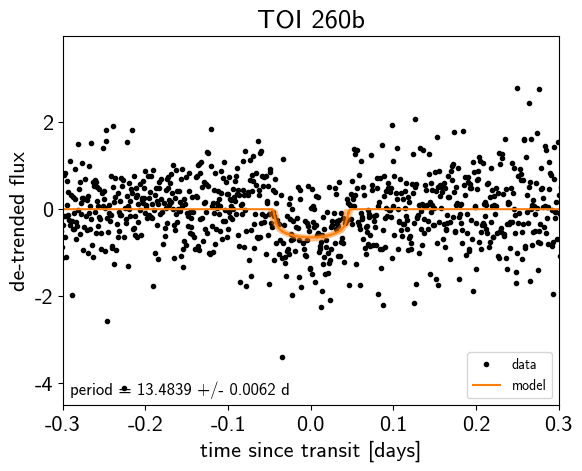

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

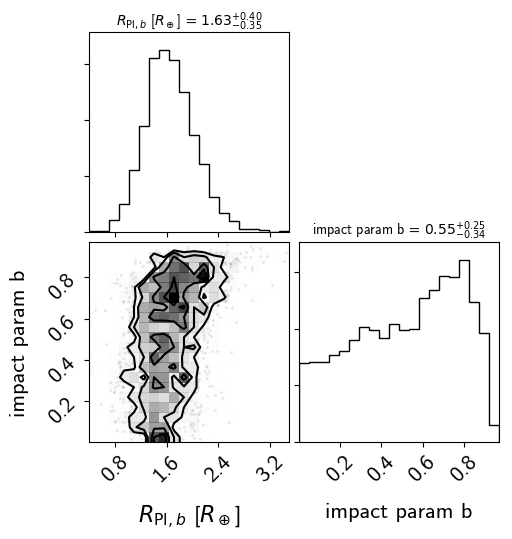

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

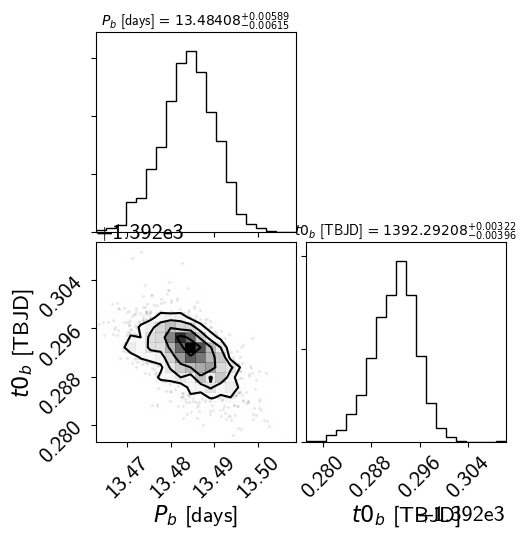

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

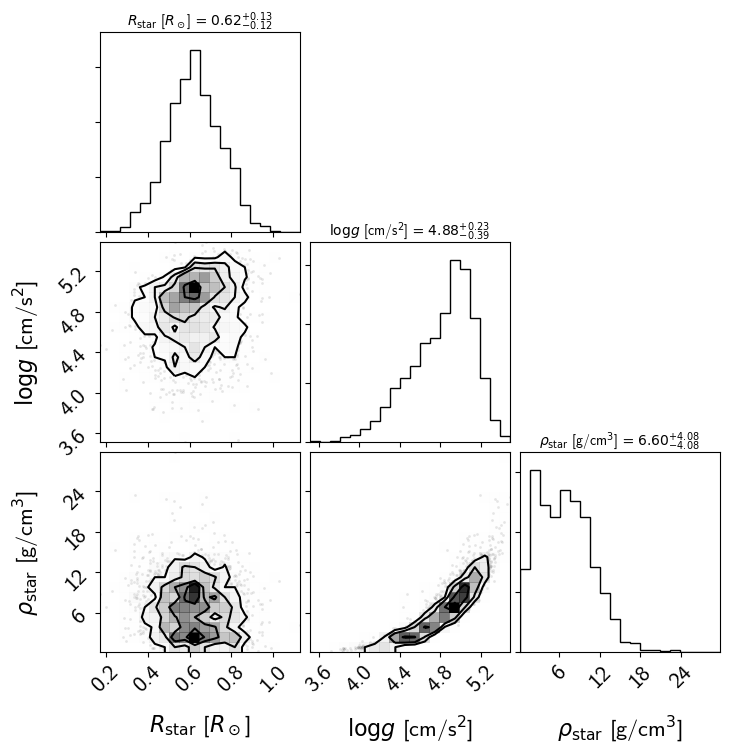

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3